# Predict Earthquake Damage to Building in Nepal

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

## Import Data

In [2]:
train_label = pd.read_csv("train_labels.csv")
train_value = pd.read_csv("train_values.csv")
test_value = pd.read_csv("test_values.csv")

## Checking Data

In [3]:
print('Train Values : {}'.format(train_value.shape))
print('Train Labels : {}'.format(train_label.shape))
print('Test Values : {}'.format(test_value.shape))

Train Values : (260601, 39)
Train Labels : (260601, 2)
Test Values : (86868, 39)


In [4]:
print('Number of Training Data : {}'.format(train_value.shape[0]))
print('Number of Testing Data : {}'.format(test_value.shape[0]))
print('Total Data : {}'.format(train_value.shape[0]+test_value.shape[0]))

Number of Training Data : 260601
Number of Testing Data : 86868
Total Data : 347469


In [5]:
train_label.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [6]:
train_value.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_value.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,300051,17,596,11307,3,20,7,6,t,r,...,0,0,0,0,0,0,0,0,0,0
1,99355,6,141,11987,2,25,13,5,t,r,...,1,0,0,0,0,0,0,0,0,0
2,890251,22,19,10044,2,5,4,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,745817,26,39,633,1,0,19,3,t,r,...,0,0,1,0,0,0,0,0,0,0
4,421793,17,289,7970,3,15,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0


## Data Preparation

### Merge Feature and Label on Training Data

In [8]:
train = pd.merge(train_value, train_label)

In [9]:
# Add new interaction features
train['age_x_area'] = train['age'] * train['area_percentage']
train['age_x_height'] = train['age'] * train['height_percentage']
train['floors_x_area'] = train['count_floors_pre_eq'] * train['area_percentage']
train['floors_x_height'] = train['count_floors_pre_eq'] * train['height_percentage']

# Add ratio features
train['area_per_floor'] = train['area_percentage'] / (train['count_floors_pre_eq'] + 1)
train['height_per_floor'] = train['height_percentage'] / (train['count_floors_pre_eq'] + 1)
train['area_to_height'] = train['area_percentage'] / (train['height_percentage'] + 1)

# Add binned features
train['age_bin'] = pd.cut(train['age'], bins=[0, 10, 30, 60, 100], labels=[0,1,2,3])
train['area_bin'] = pd.cut(train['area_percentage'], bins=[0, 20, 40, 60, 100], labels=[0,1,2,3])

# Add composite categorical feature
train['foundation_roof_combo'] = train['foundation_type'] + '_' + train['roof_type']

In [10]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,age_x_area,age_x_height,floors_x_area,floors_x_height,area_per_floor,height_per_floor,area_to_height,age_bin,area_bin,foundation_roof_combo
0,802906,6,487,12198,2,30,6,5,t,r,...,180,150,12,10,2.000000,1.666667,1.000000,1,0,r_n
1,28830,8,900,2812,2,10,8,7,o,r,...,80,70,16,14,2.666667,2.333333,1.000000,0,0,r_n
2,94947,21,363,8973,2,10,5,5,t,r,...,50,50,10,10,1.666667,1.666667,0.833333,0,0,r_n
3,590882,22,418,10694,2,10,6,5,t,r,...,60,50,12,10,2.000000,1.666667,1.000000,0,0,r_n
4,201944,11,131,1488,3,30,8,9,t,r,...,240,270,24,27,2.000000,2.250000,0.800000,1,0,r_n


### Check Null and Duplicate Data

In [11]:
train.isnull().sum()

building_id                                   0
geo_level_1_id                                0
geo_level_2_id                                0
geo_level_3_id                                0
count_floors_pre_eq                           0
age                                           0
area_percentage                               0
height_percentage                             0
land_surface_condition                        0
foundation_type                               0
roof_type                                     0
ground_floor_type                             0
other_floor_type                              0
position                                      0
plan_configuration                            0
has_superstructure_adobe_mud                  0
has_superstructure_mud_mortar_stone           0
has_superstructure_stone_flag                 0
has_superstructure_cement_mortar_stone        0
has_superstructure_mud_mortar_brick           0
has_superstructure_cement_mortar_brick  

In [12]:
print('Ukuran data sebelum drop duplicate :', train.shape)
train = train.drop_duplicates(subset='building_id', keep='last')
print('Ukuran data setelah drop duplicate :', train.shape)

Ukuran data sebelum drop duplicate : (260601, 50)
Ukuran data setelah drop duplicate : (260601, 50)


### Check Data Columns and Info

In [13]:
train.columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_i

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 50 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int64   
 1   geo_level_1_id                          260601 non-null  int64   
 2   geo_level_2_id                          260601 non-null  int64   
 3   geo_level_3_id                          260601 non-null  int64   
 4   count_floors_pre_eq                     260601 non-null  int64   
 5   age                                     260601 non-null  int64   
 6   area_percentage                         260601 non-null  int64   
 7   height_percentage                       260601 non-null  int64   
 8   land_surface_condition                  260601 non-null  object  
 9   foundation_type                         260601 non-null  object  
 10  roof_type                       

### Data Numeric and Categorical

#### Numeric

In [15]:
train.select_dtypes(include=['int64']).columns

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'damage_grade', 'age_x_ar

#### Categorical

In [16]:
train.select_dtypes(include=['object']).columns

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status',
       'foundation_roof_combo'],
      dtype='object')

### Summary Data

In [17]:
train.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_use_police,has_secondary_use_other,damage_grade,age_x_area,age_x_height,floors_x_area,floors_x_height,area_per_floor,height_per_floor,area_to_height
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.000088,0.005119,2.238272,211.362524,152.820327,17.399258,12.652400,2.673370,1.719426,1.318045
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.009394,0.071364,0.611814,682.953677,447.342923,12.856820,9.001663,1.615051,0.389626,0.786932
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.166667,0.250000,0.060606
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,2.000000,50.000000,40.000000,10.000000,8.000000,1.666667,1.500000,0.857143
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,2.000000,120.000000,90.000000,14.000000,10.000000,2.333333,1.666667,1.166667
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,3.000000,220.000000,160.000000,21.000000,15.000000,3.000000,2.000000,1.500000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,3.000000,33830.000000,17910.000000,800.000000,208.000000,43.000000,16.000000,21.500000


In [18]:
train.describe(include='object')

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status,foundation_roof_combo
count,260601,260601,260601,260601,260601,260601,260601,260601,260601
unique,3,5,3,5,4,4,10,4,14
top,t,r,n,f,q,s,d,v,r_n
freq,216757,219196,182842,209619,165282,202090,250072,250939,165167


## Exploratory Data Analysis (EDA)

### Plot Label Data

In [19]:
train['damage_grade'] = train['damage_grade'].astype('category')
train['damage_grade'] = train['damage_grade'].replace({1:'Low', 2:'Medium', 3:'High'})

In [20]:
train['damage_grade'].unique()

['High', 'Medium', 'Low']
Categories (3, object): ['Low', 'Medium', 'High']

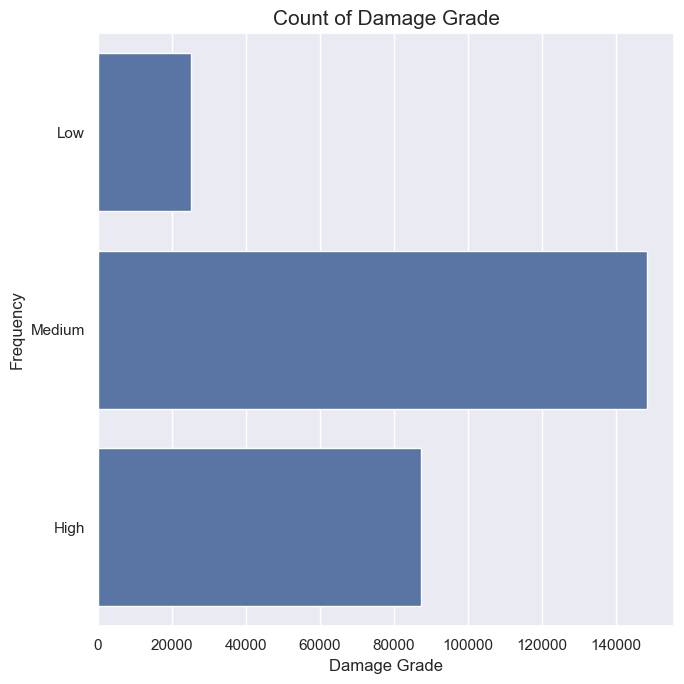

In [21]:
plt.figure(figsize=(7,7))

sns.set_theme()
sns.countplot(train['damage_grade'], order=['Low', 'Medium', 'High'])
plt.xlabel('Damage Grade', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Count of Damage Grade', fontsize=15)
plt.tight_layout()
plt.show()

In [22]:
print('Jumlah Bangunan dengan tingkat kerusakan rendah : {}'.format(sum(train['damage_grade']=='Low')))
print('Jumlah Bangunan dengan tingkat kerusakan menengah : {}'.format(sum(train['damage_grade']=='Medium')))
print('Jumlah Bangunan dengan tingkat kerusakan tinggi : {}'.format(sum(train['damage_grade']=='High')))
print('')
print('Persentase Bangunan dengan tingkat kerusakan rendah : {:.2f}%'.format(sum(train['damage_grade']=='Low')/train.shape[0]*100))
print('Persentase Bangunan dengan tingkat kerusakan menengah : {:.2f}%'.format(sum(train['damage_grade']=='Medium')/train.shape[0]*100))
print('Persentase Bangunan dengan tingkat kerusakan tinggi : {:.2f}%'.format(sum(train['damage_grade']=='High')/train.shape[0]*100))

Jumlah Bangunan dengan tingkat kerusakan rendah : 25124
Jumlah Bangunan dengan tingkat kerusakan menengah : 148259
Jumlah Bangunan dengan tingkat kerusakan tinggi : 87218

Persentase Bangunan dengan tingkat kerusakan rendah : 9.64%
Persentase Bangunan dengan tingkat kerusakan menengah : 56.89%
Persentase Bangunan dengan tingkat kerusakan tinggi : 33.47%


### Check Between Feature and Label

#### Geo Level and Damage Grade

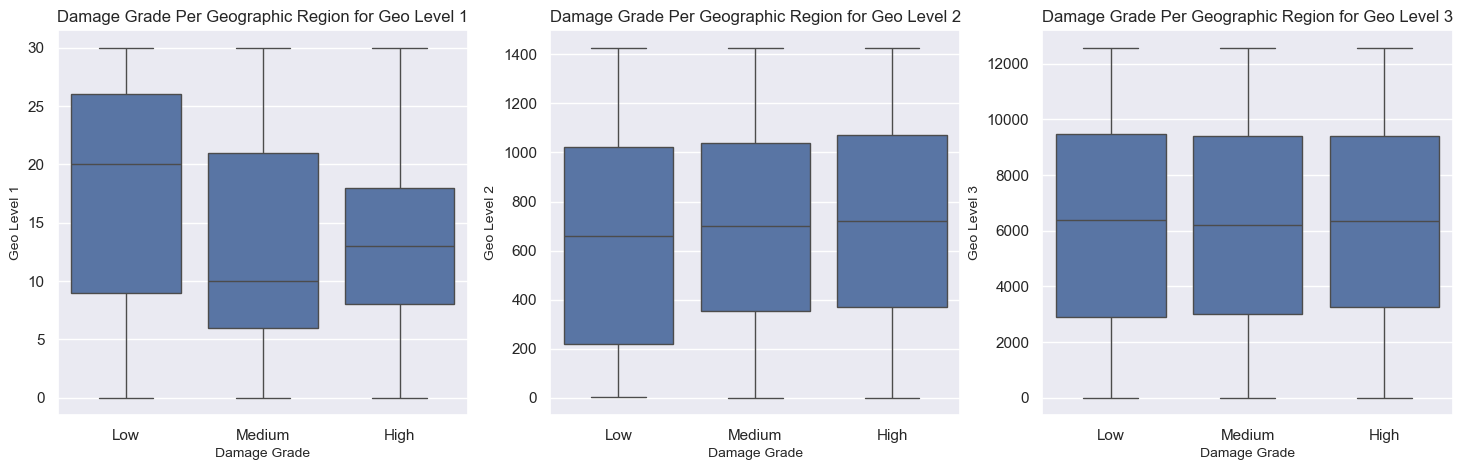

In [23]:
fig = plt.figure(figsize=(18,5))

geo_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

for i in range(1,4):
    plt.subplot(int(f'13{i}'))
    sns.boxplot(x='damage_grade', y=geo_col[i-1], data=train)
    plt.xlabel('Damage Grade', fontsize=10)
    plt.ylabel(f'Geo Level {i}', fontsize=10)
    plt.title(f'Damage Grade Per Geographic Region for Geo Level {i}')
plt.show()

#### Number of Floor & Count Families and Damage Grade

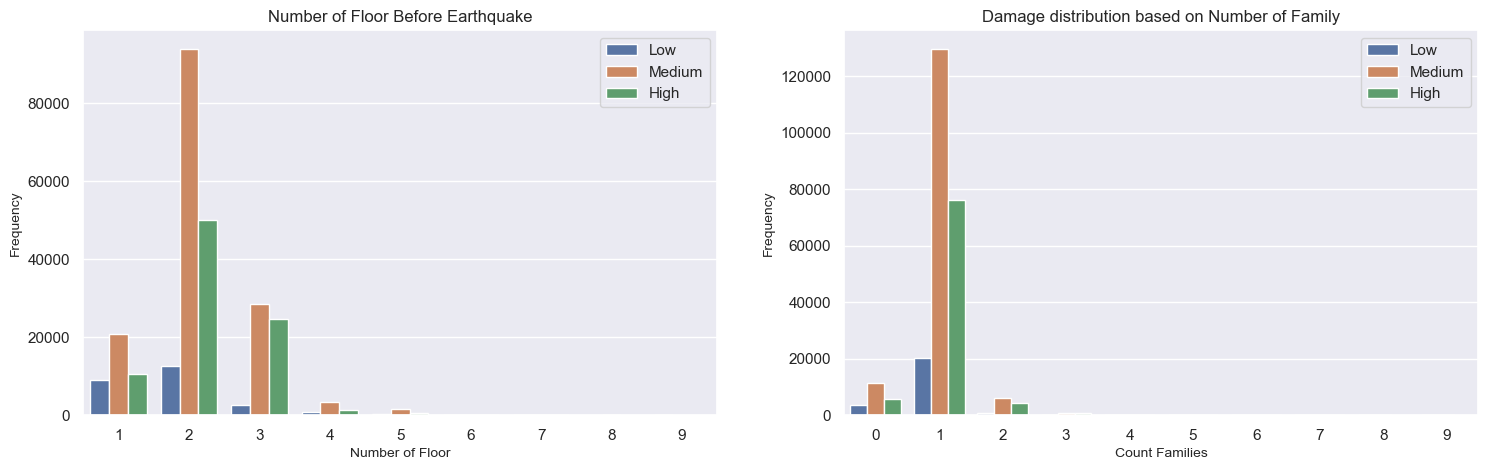

In [24]:
fig = plt.figure(figsize=(18,5))

floor_family_col = ['count_floors_pre_eq', 'count_families']
floor_family_label = ['Number of Floor', 'Count Families']
floor_family_title = ['Number of Floor Before Earthquake', 'Damage distribution based on Number of Family']

for i in range(1,3):
    plt.subplot(int(f'12{i}'))
    sns.countplot(x=floor_family_col[i-1], hue='damage_grade', data=train)
    plt.xlabel(f'{floor_family_label[i-1]}', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'{floor_family_title[i-1]}')
    plt.legend(loc='upper right')
plt.show()

#### Age and Damage Grade

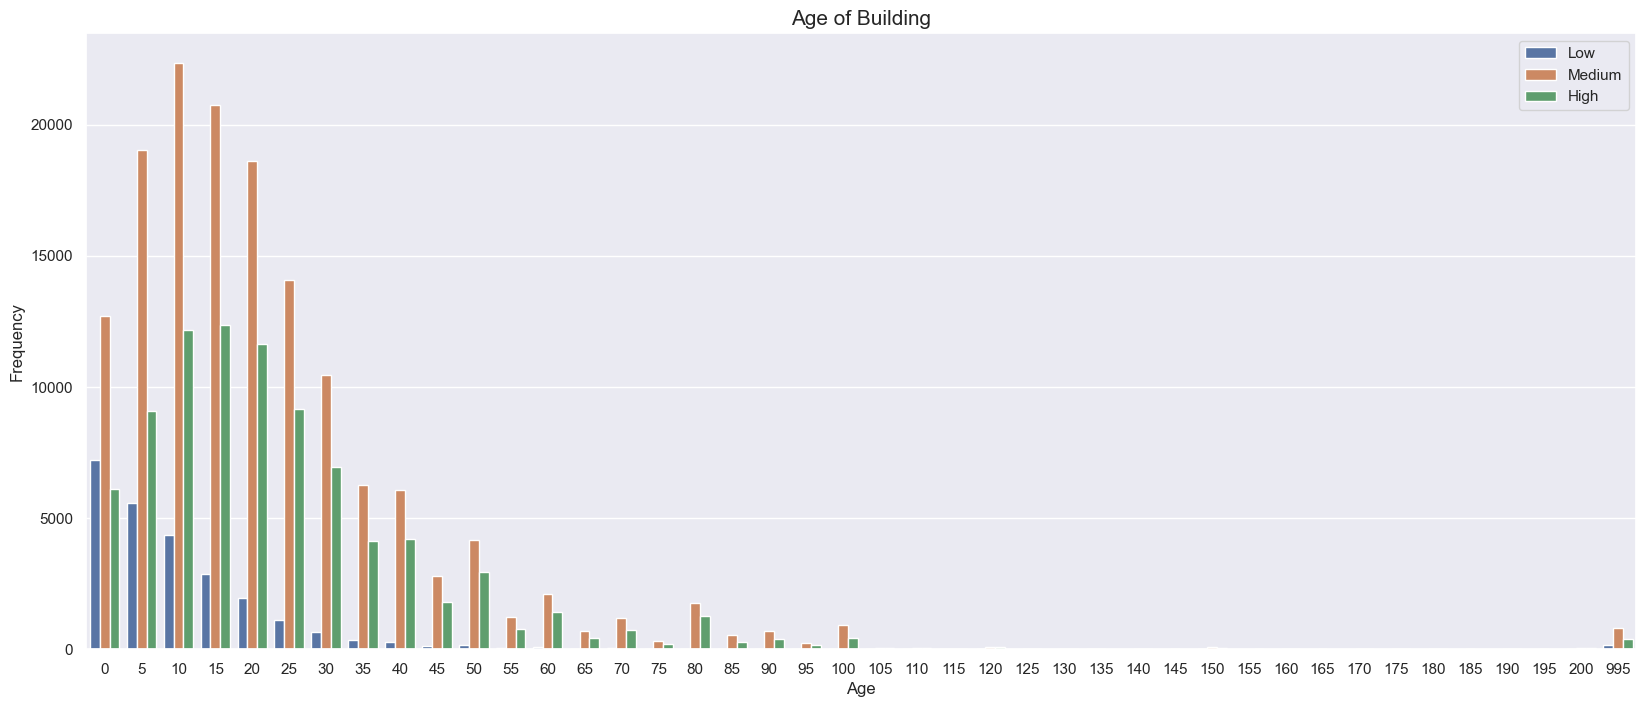

In [25]:
plt.figure(figsize=(20,8))

sns.countplot(x='age', hue='damage_grade', data=train)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Age of Building', fontsize=15)
plt.legend(loc='upper right')
plt.show()

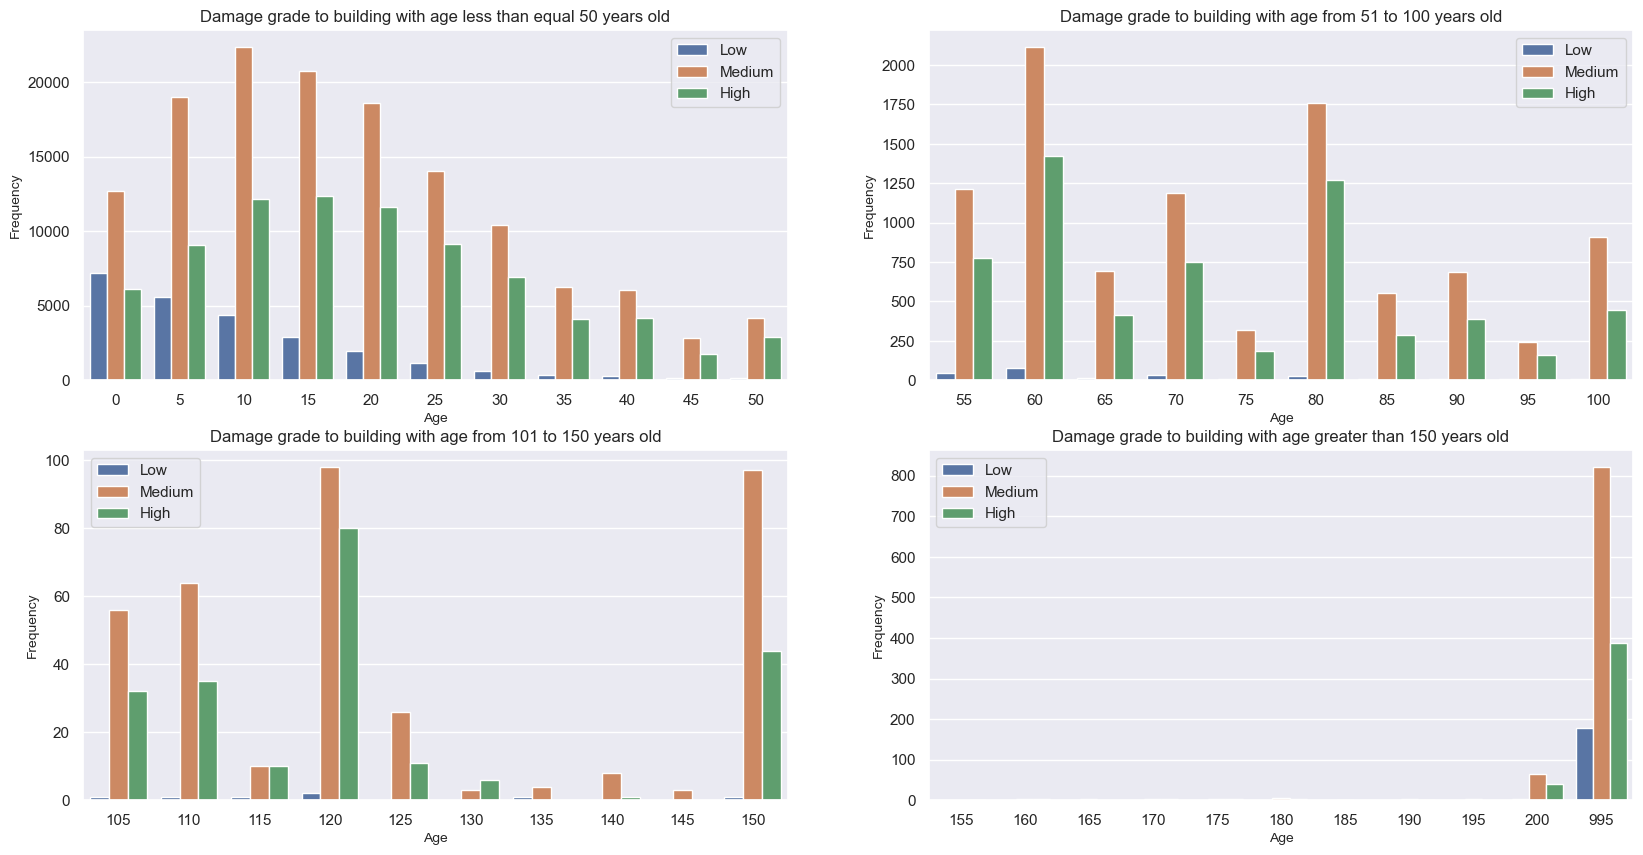

In [26]:
fig = plt.figure(figsize=(20,10))

segment_1_age = train[train['age']<=50]
segment_2_age = train[(train['age']>50) & (train['age']<=100)]
segment_3_age = train[(train['age']>100) & (train['age']<=150)]
segment_4_age = train[train['age']>150]

segment = [segment_1_age, segment_2_age, segment_3_age, segment_4_age]
segment_title = ['less than equal 50 years old', 'from 51 to 100 years old',
                 'from 101 to 150 years old', 'greater than 150 years old']
segment_legend_loc = ['upper right', 'upper right', 'upper left', 'upper left']

for i in range(1,5):
    plt.subplot(int(f'22{i}'))
    sns.countplot(x='age', hue='damage_grade', data=segment[i-1])
    plt.xlabel('Age', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage grade to building with age {segment_title[i-1]}', fontsize=12)
    plt.legend(loc=segment_legend_loc[i-1])
plt.show()

#### Area & Height Percentage and Damage Grade

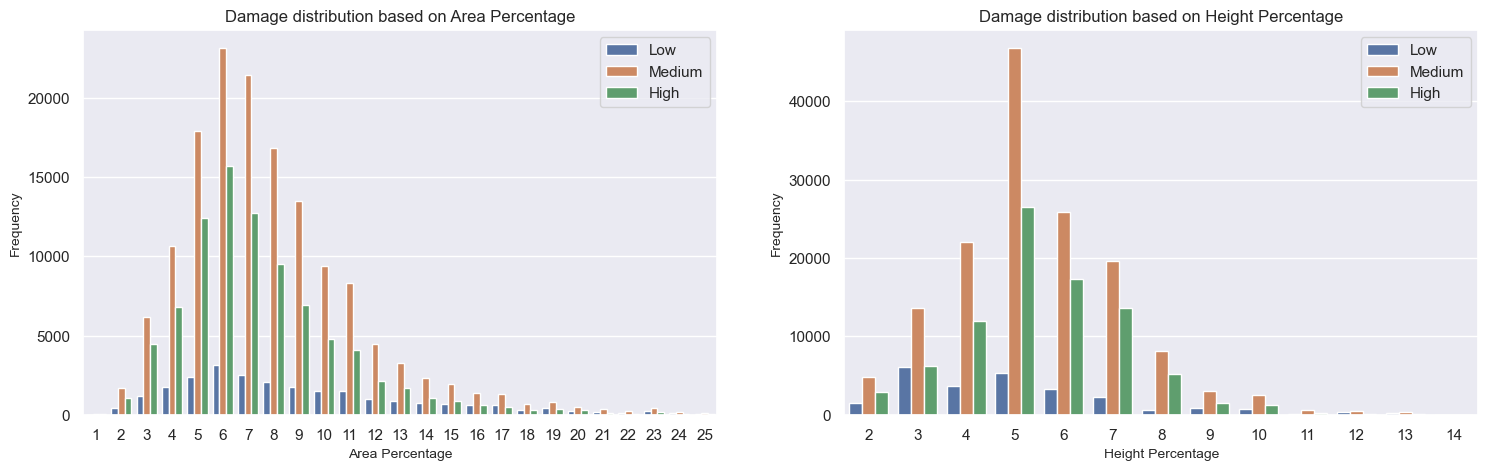

In [27]:
fig = plt.figure(figsize=(18,5))

area_segment = train[train['area_percentage'] <= 25]
height_segment = train[train['height_percentage'] <= 14]

area_height_col = ['area_percentage', 'height_percentage']
area_height_segment = [area_segment, height_segment]
area_height_label = ['Area', 'Height']

for i in range(1,3):
    plt.subplot(int(f'12{i}'))
    sns.countplot(x=area_height_col[i-1], hue='damage_grade', data=area_height_segment[i-1])
    plt.xlabel(f'{area_height_label[i-1]} Percentage', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage distribution based on {area_height_label[i-1]} Percentage')
    plt.legend(loc='upper right')
plt.show()

#### Categorical Column and Damage Grade

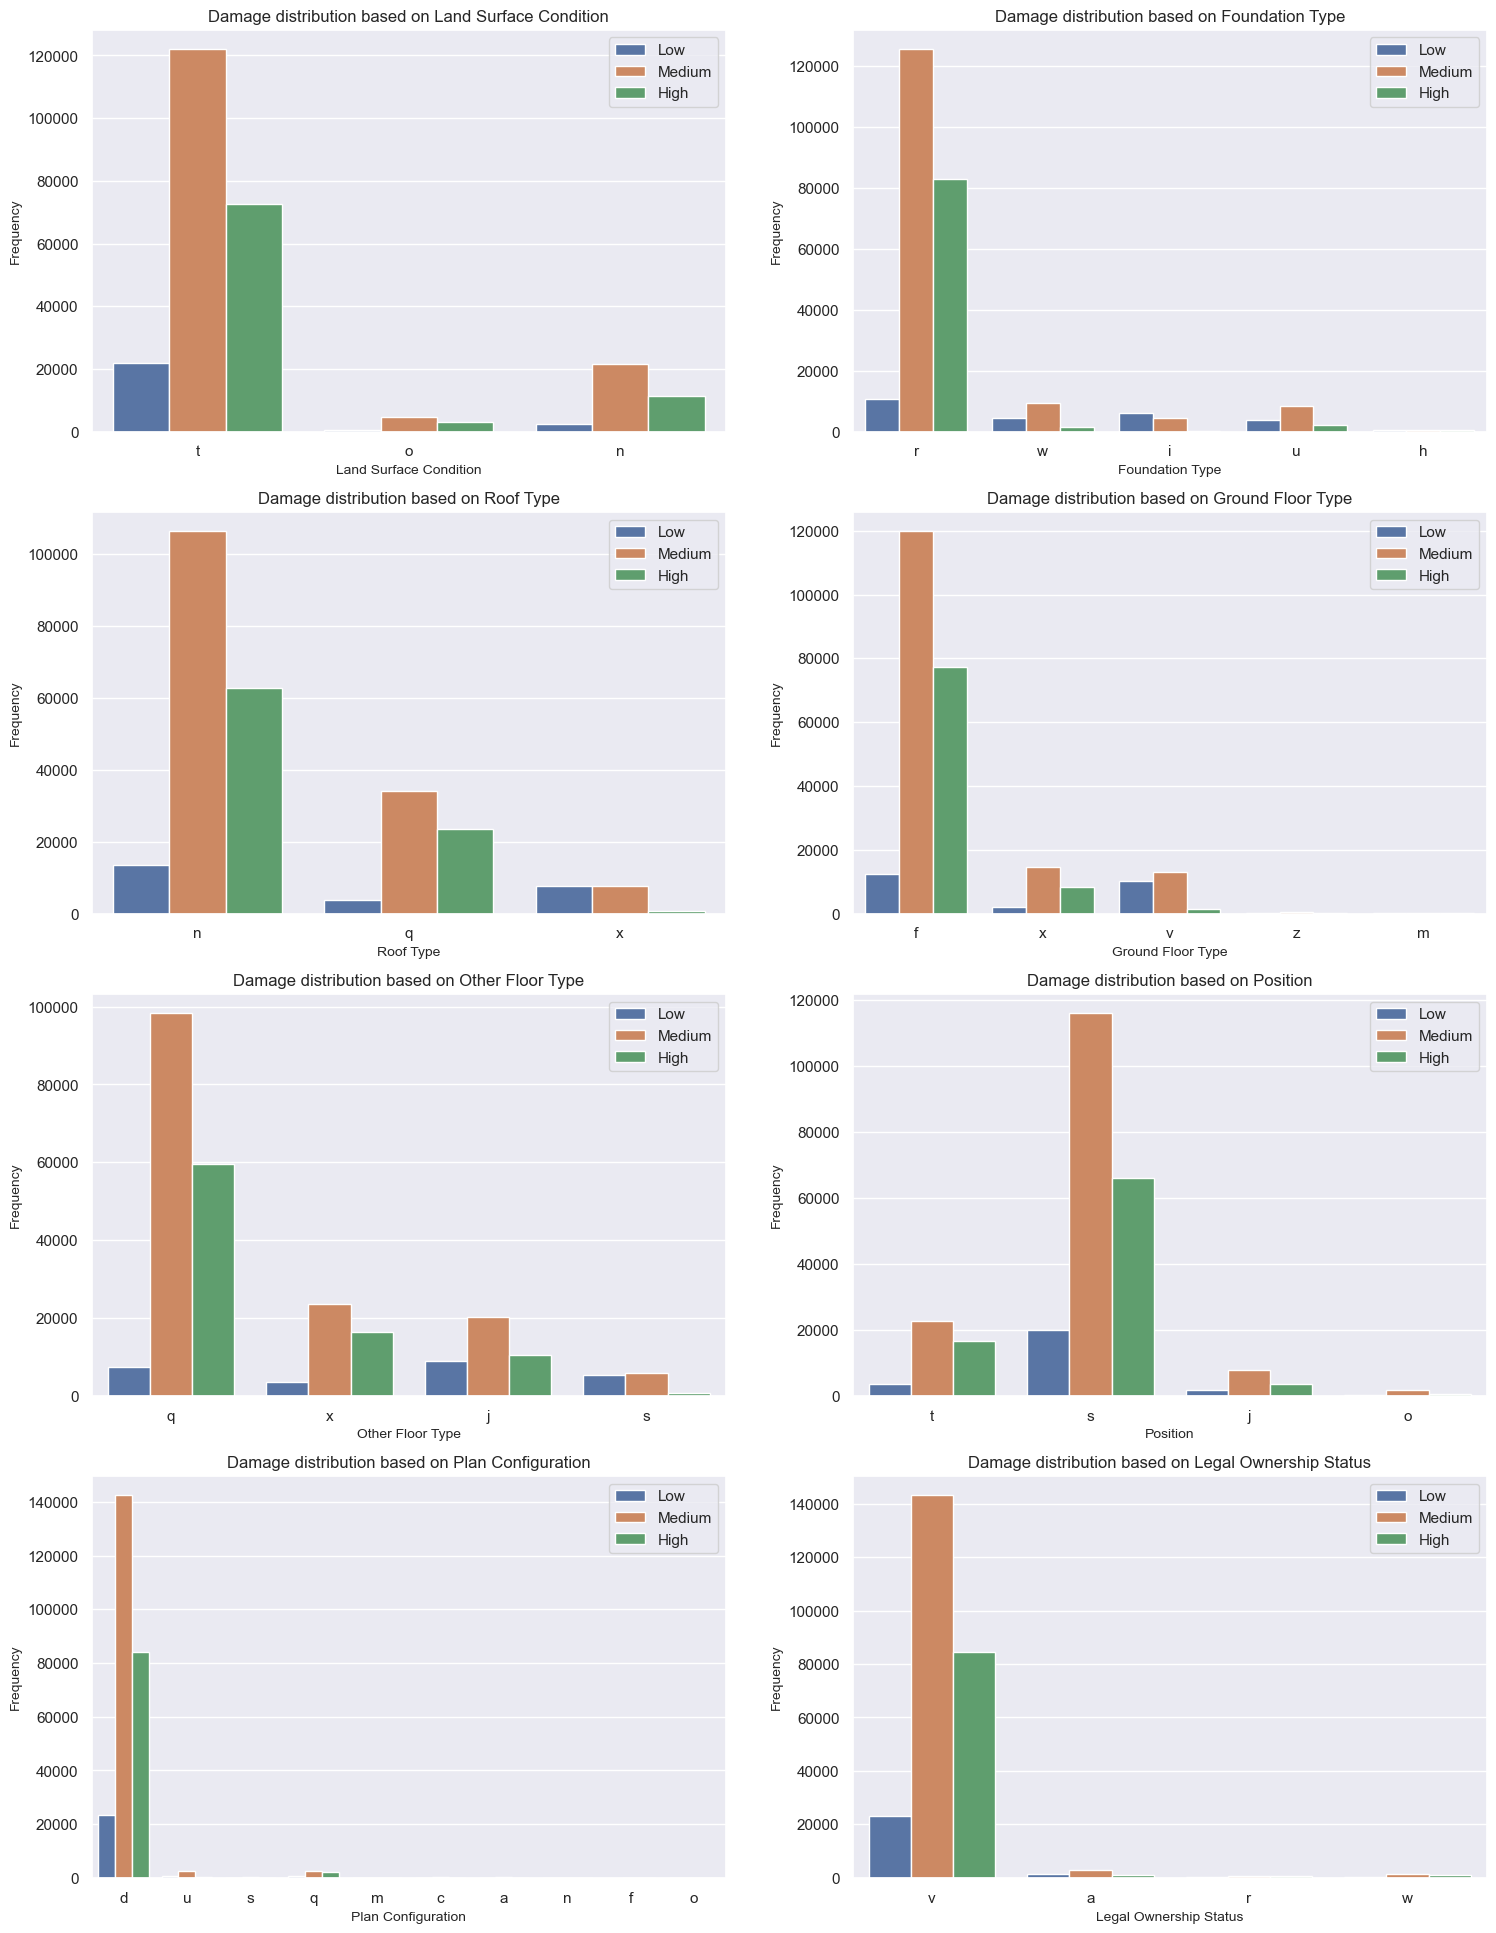

In [28]:
fig = plt.figure(figsize=(18,24))

cat_col = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type',
                   'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status']
cat_col_label = ['Land Surface Condition', 'Foundation Type', 'Roof Type', 'Ground Floor Type',
                 'Other Floor Type', 'Position', 'Plan Configuration', 'Legal Ownership Status']

for i in range(1,9):
    plt.subplot(int(f'42{i}'))
    sns.countplot(x=cat_col[i-1], hue='damage_grade', data=train)
    plt.xlabel(f'{cat_col_label[i-1]}', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage distribution based on {cat_col_label[i-1]}')
    plt.legend(loc='upper right')
plt.show()

#### Numerical Feature (Binary) and Damage Grade

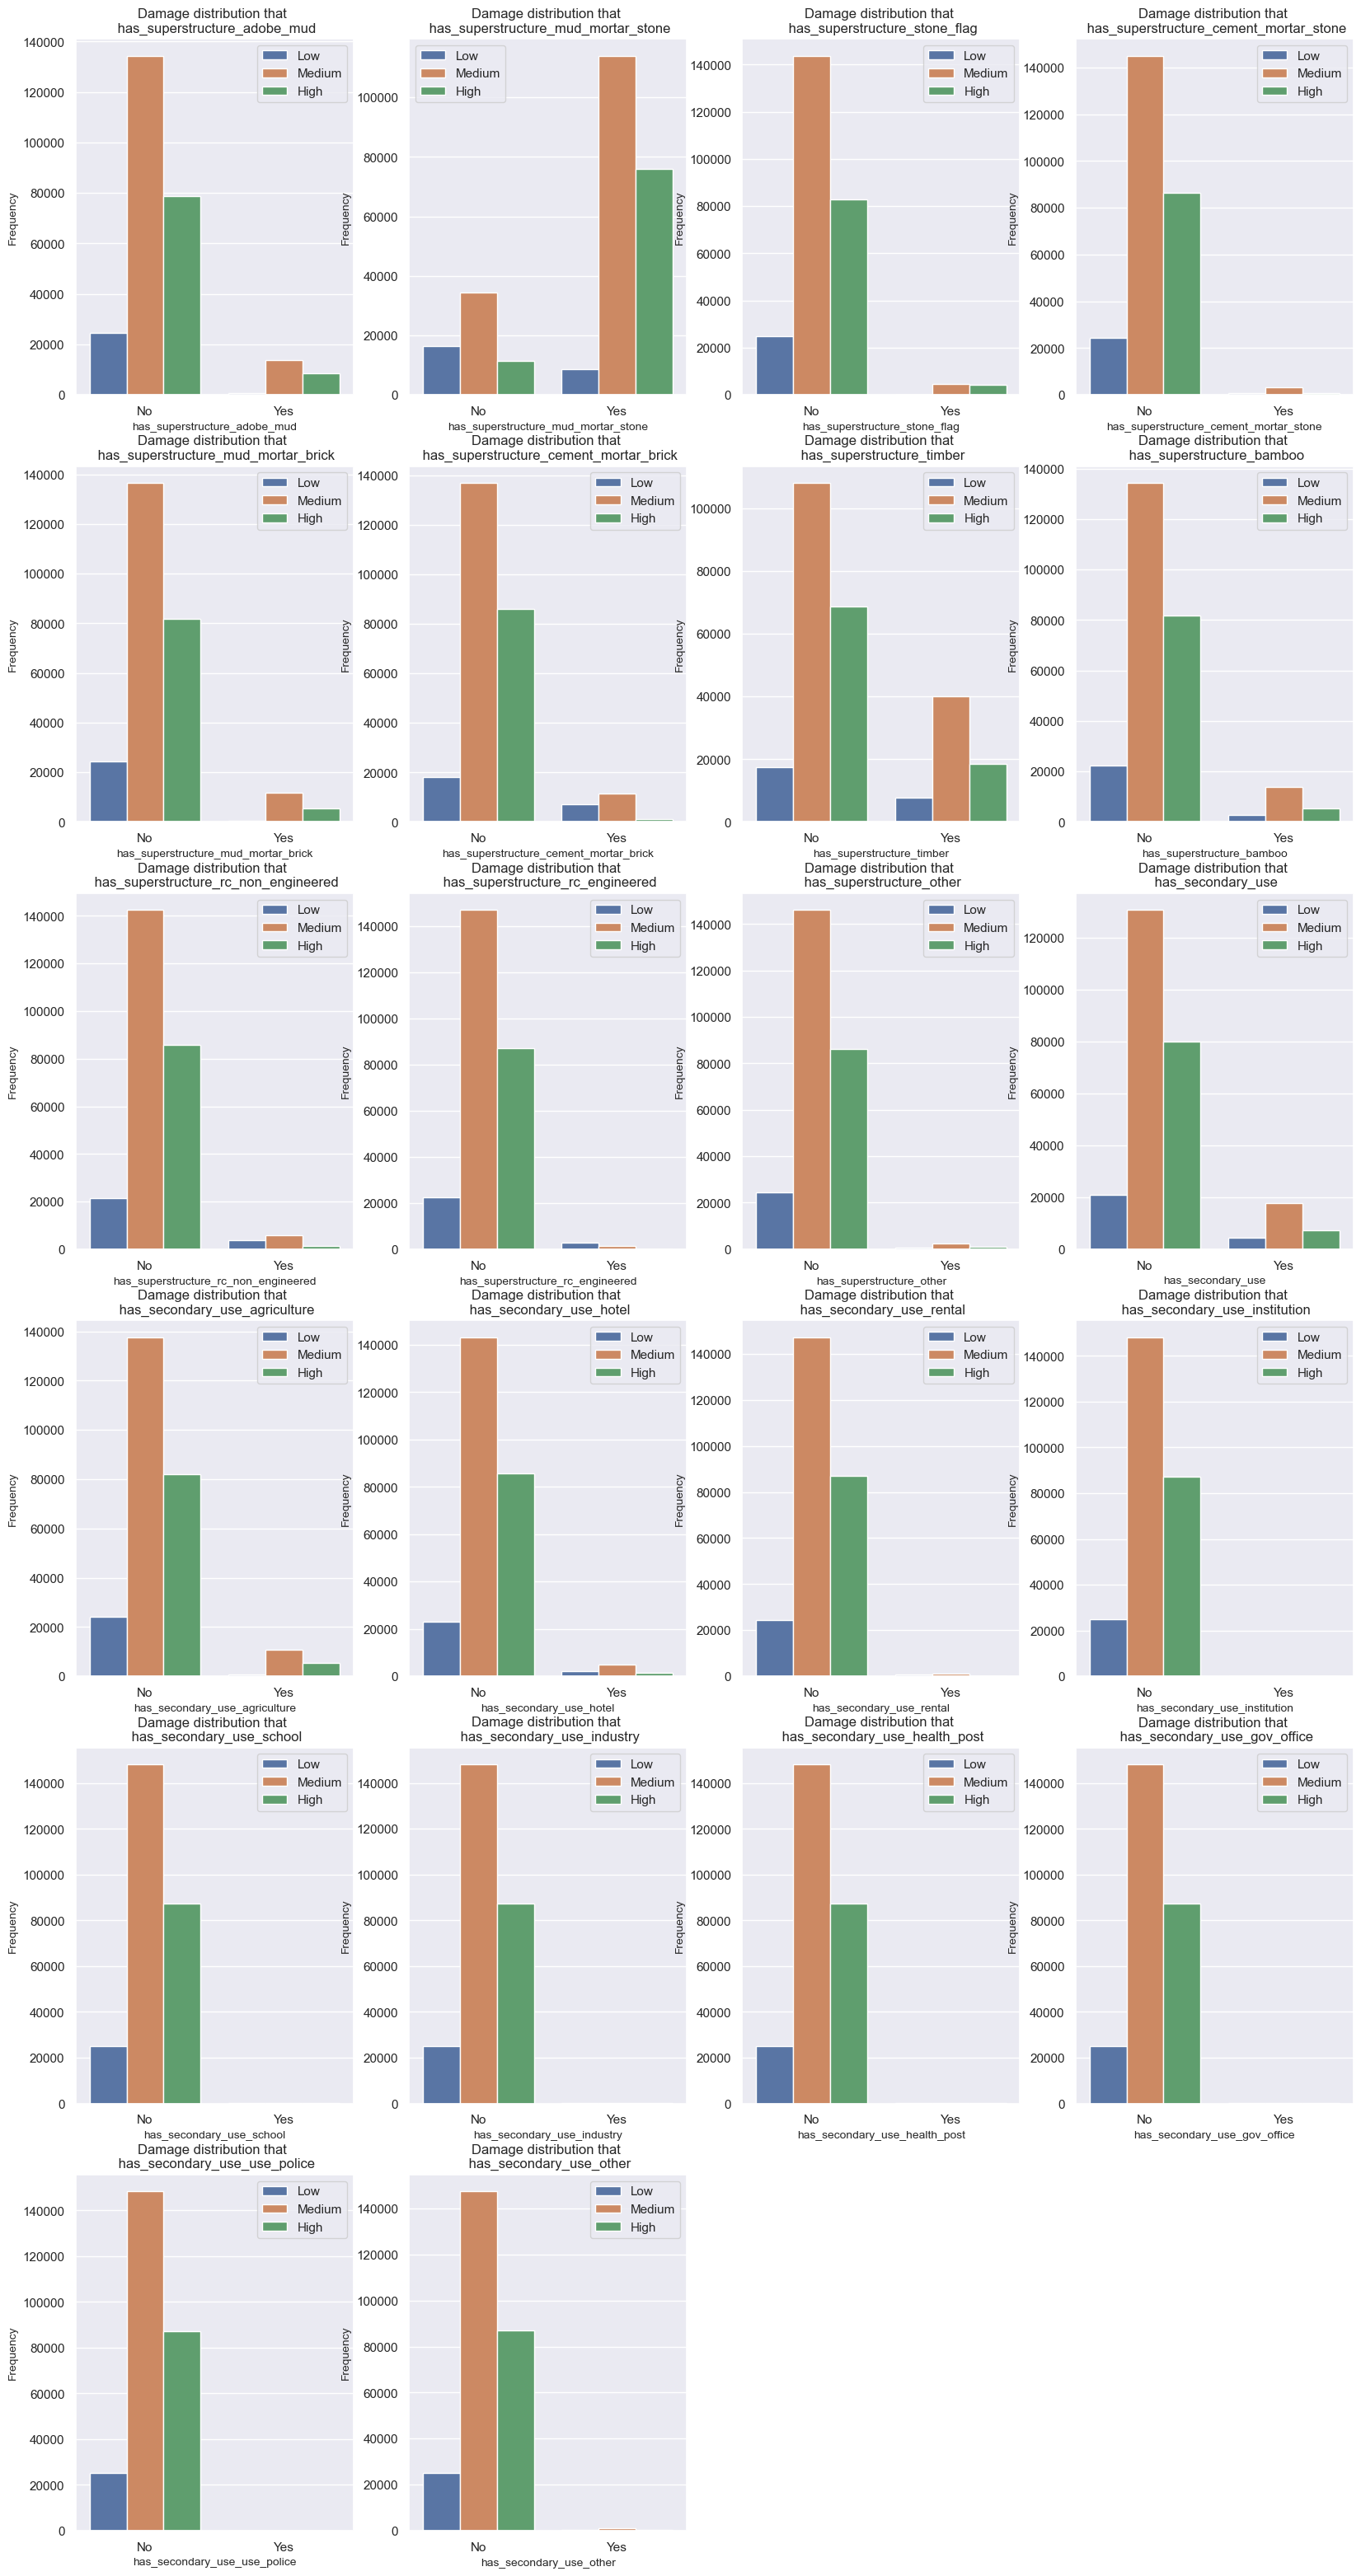

In [29]:
fig = plt.figure(figsize=(20,46))

binary_col = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 
              'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 
              'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick',
              'has_superstructure_timber', 'has_superstructure_bamboo',
              'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
              'has_superstructure_other', 'has_secondary_use', 
              'has_secondary_use_agriculture', 'has_secondary_use_hotel',
              'has_secondary_use_rental', 'has_secondary_use_institution',
              'has_secondary_use_school', 'has_secondary_use_industry', 
              'has_secondary_use_health_post', 'has_secondary_use_gov_office',
              'has_secondary_use_use_police', 'has_secondary_use_other']

for i in range(1,23):
    plt.subplot(7,4,int(f'{i}'))
    p = sns.countplot(x=binary_col[i-1], hue='damage_grade', data=train)
    p.set_xticklabels(['No', 'Yes'])
    plt.xlabel(f'{binary_col[i-1]}', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title(f'Damage distribution that \n {binary_col[i-1]}')
    plt.legend(loc='best')
plt.show()

### Facetgrid

In [30]:
def facet_plot(data, col, x, x_label):
    grid = sns.FacetGrid(data, col=col, row='damage_grade', aspect=2, sharey=False)
    grid.map(plt.hist, x, bins=20)
    grid.set_xlabels(x_label)
    grid.set_ylabels('Frequency')
    plt.show()

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Number of Floor

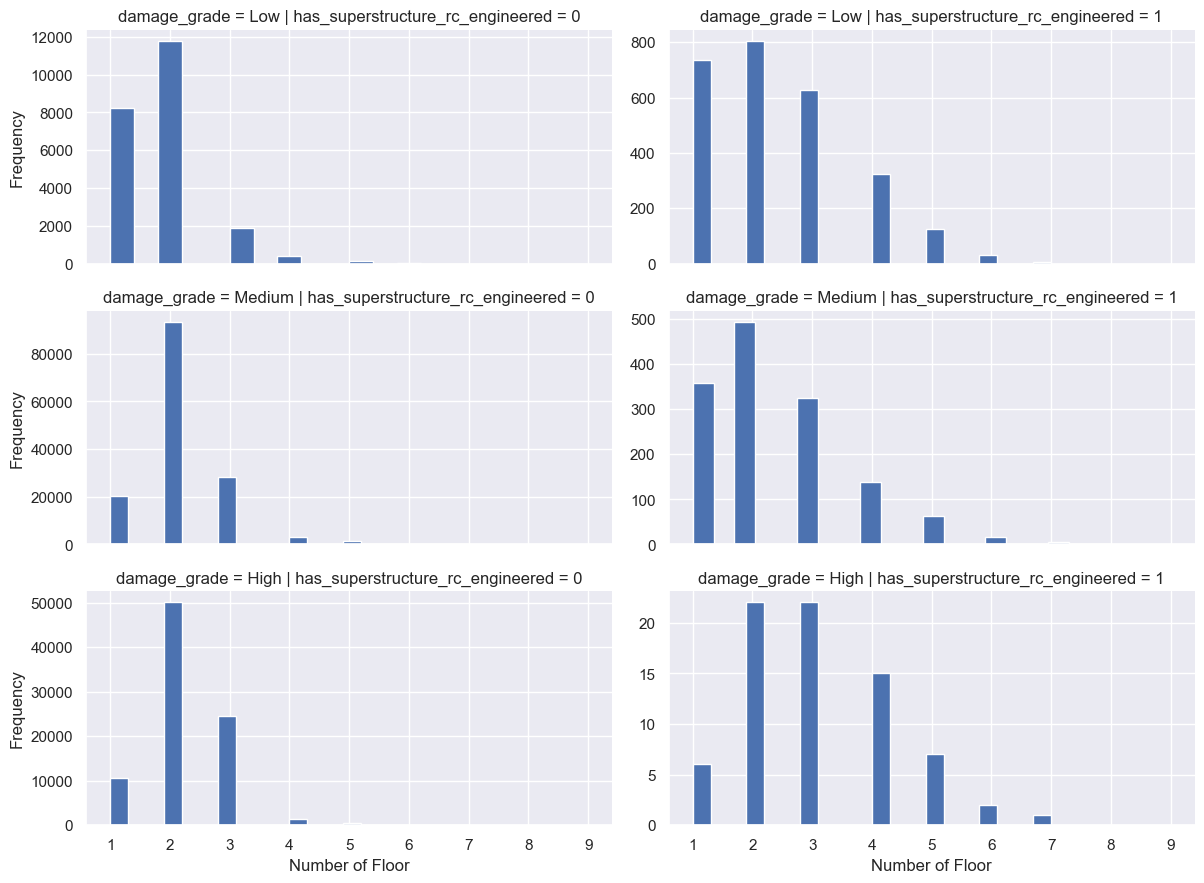

In [31]:
facet_plot(train, 'has_superstructure_rc_engineered', 'count_floors_pre_eq', 'Number of Floor')

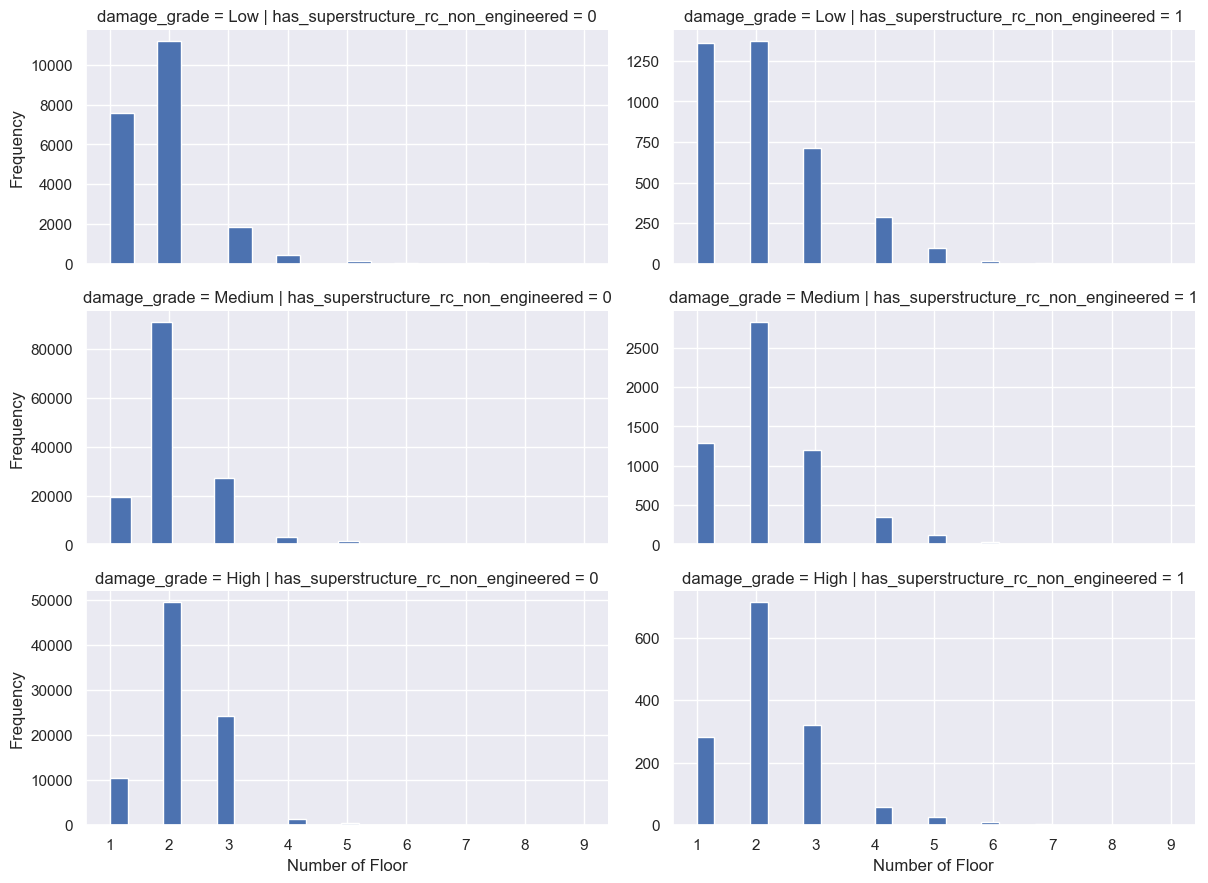

In [32]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'count_floors_pre_eq', 'Number of Floor')

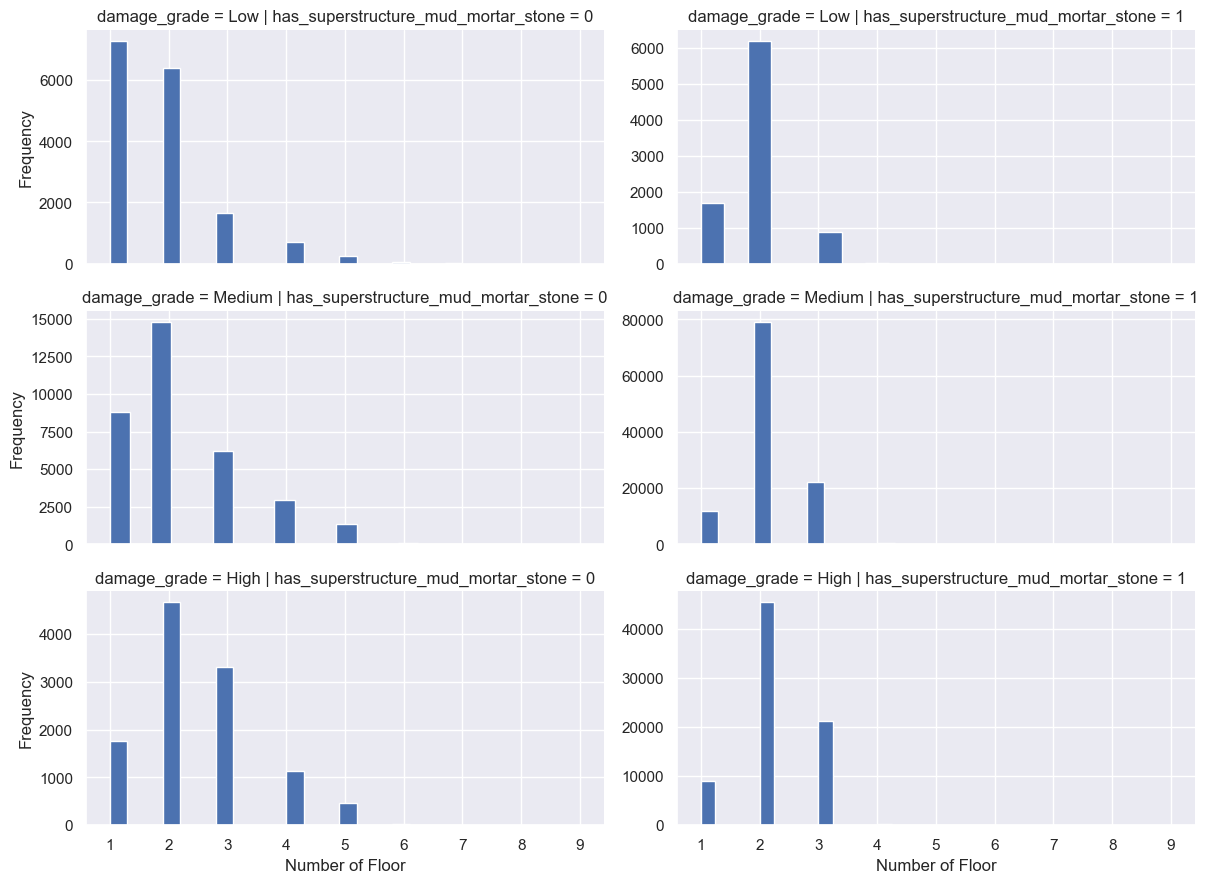

In [33]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'count_floors_pre_eq', 'Number of Floor')

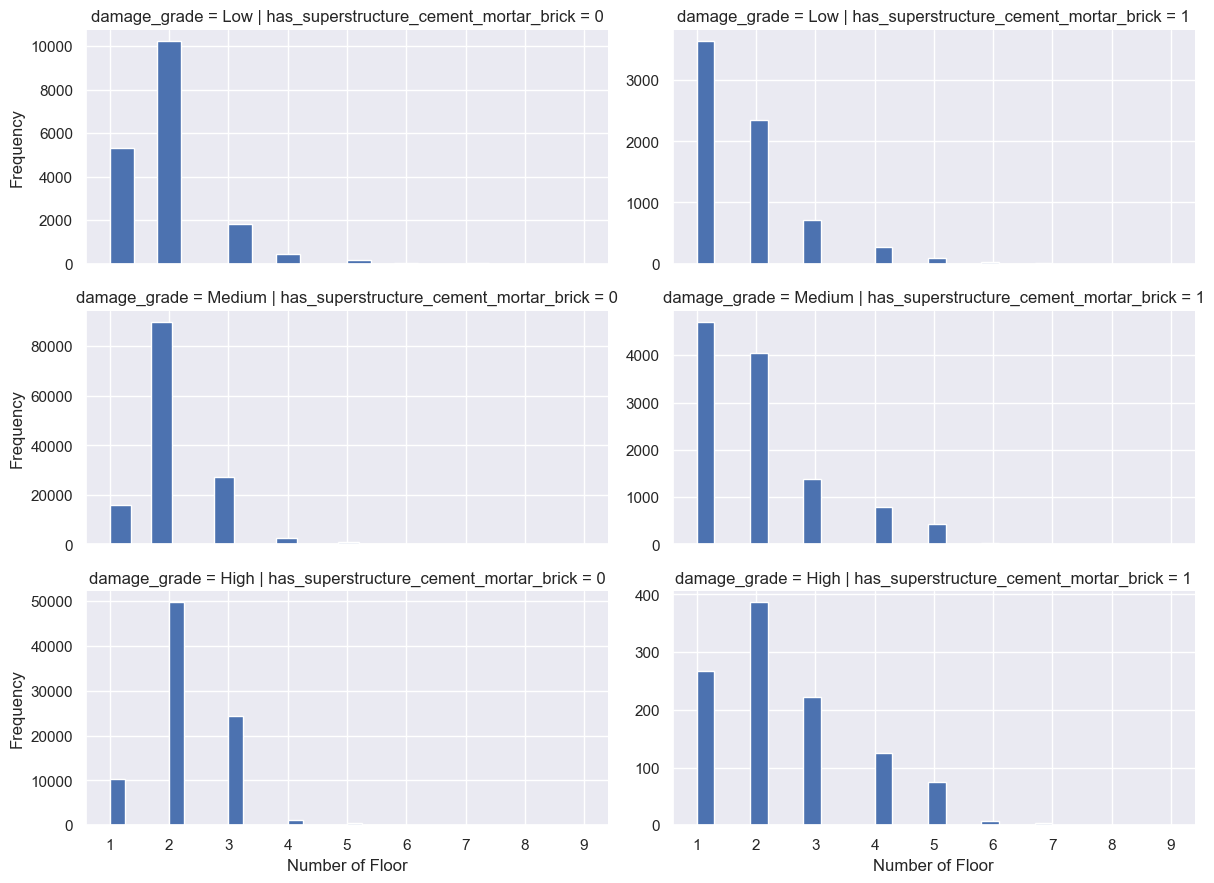

In [34]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'count_floors_pre_eq', 'Number of Floor')

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Height Percentage

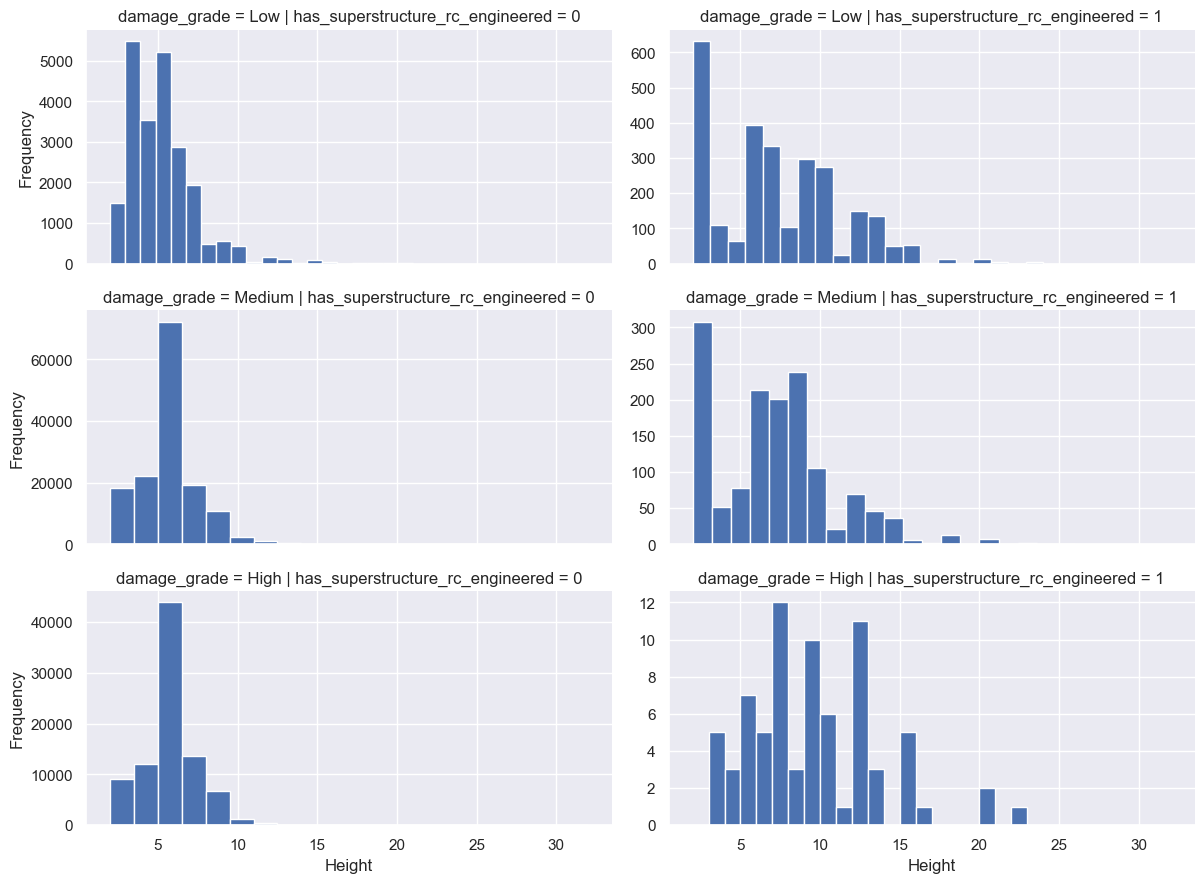

In [35]:
facet_plot(train, 'has_superstructure_rc_engineered', 'height_percentage', 'Height')

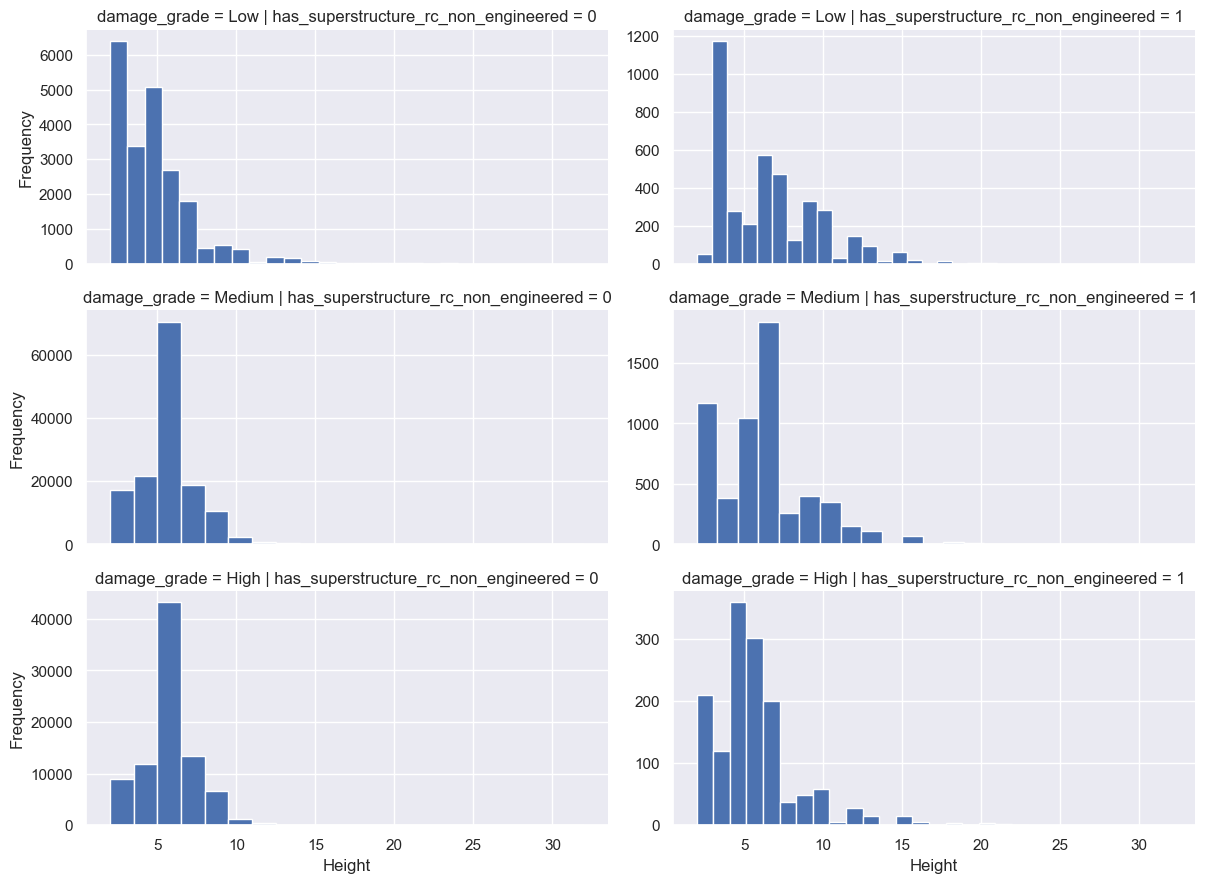

In [36]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'height_percentage', 'Height')

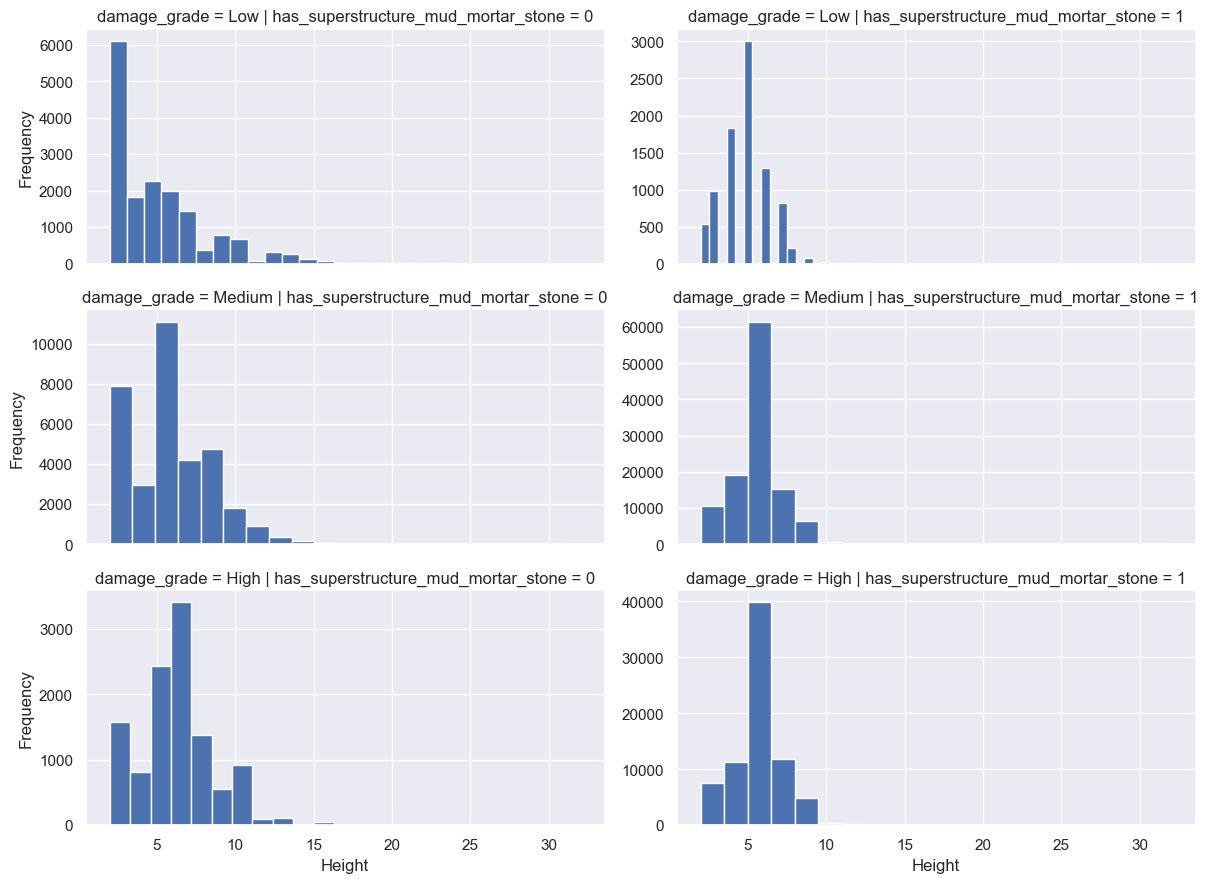

In [37]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'height_percentage', 'Height')

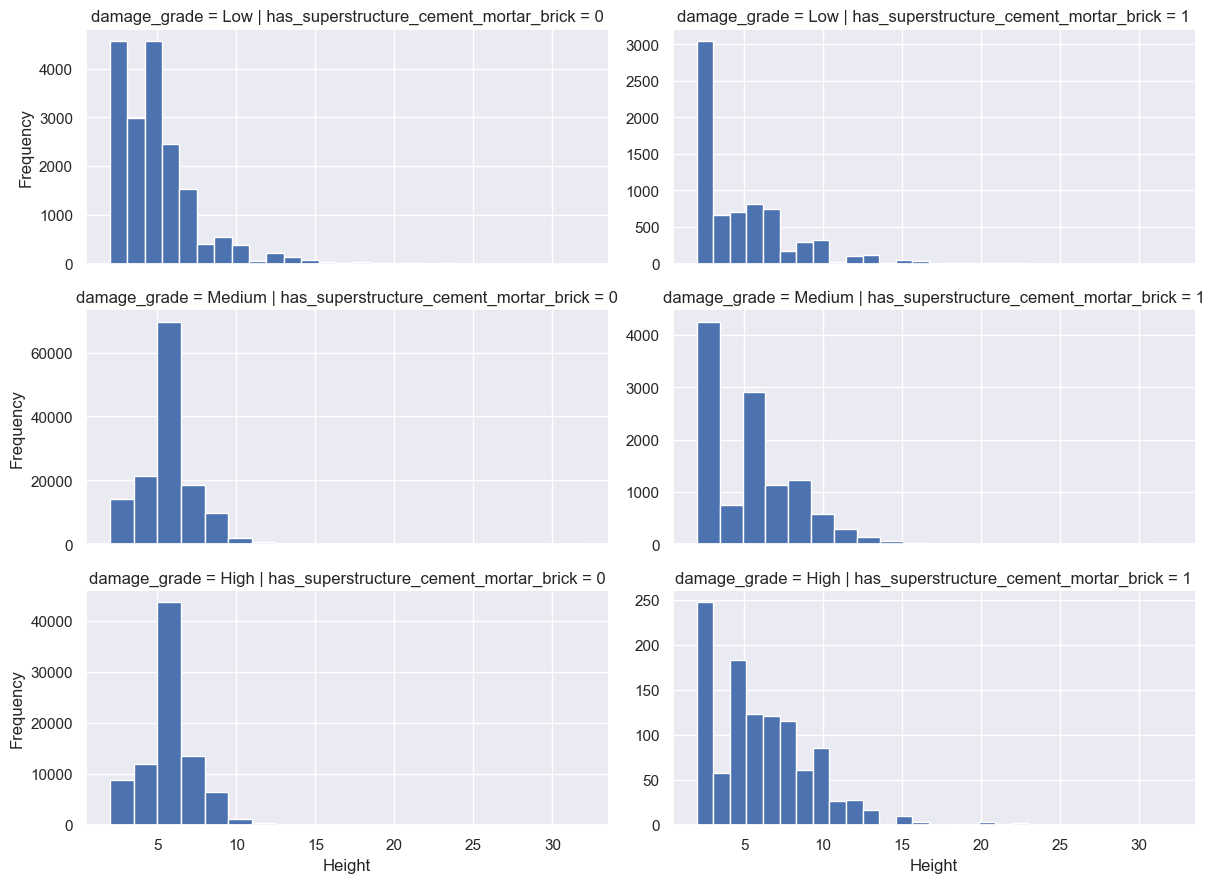

In [38]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'height_percentage', 'Height')

#### Superstructure RC, non RC, Mud Mortar Stone, Mud Mortar Brick, Cement Mortar Brick and Area Percentage

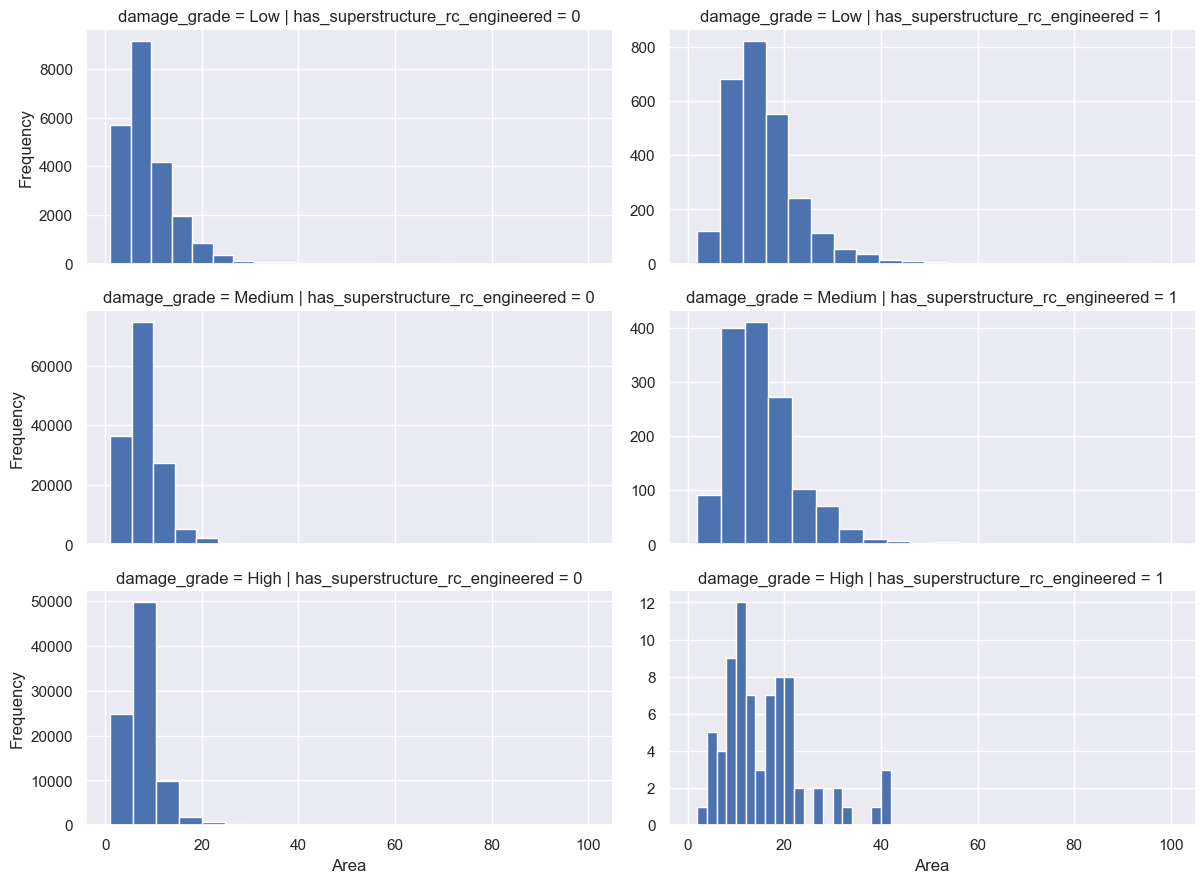

In [39]:
facet_plot(train, 'has_superstructure_rc_engineered', 'area_percentage', 'Area')

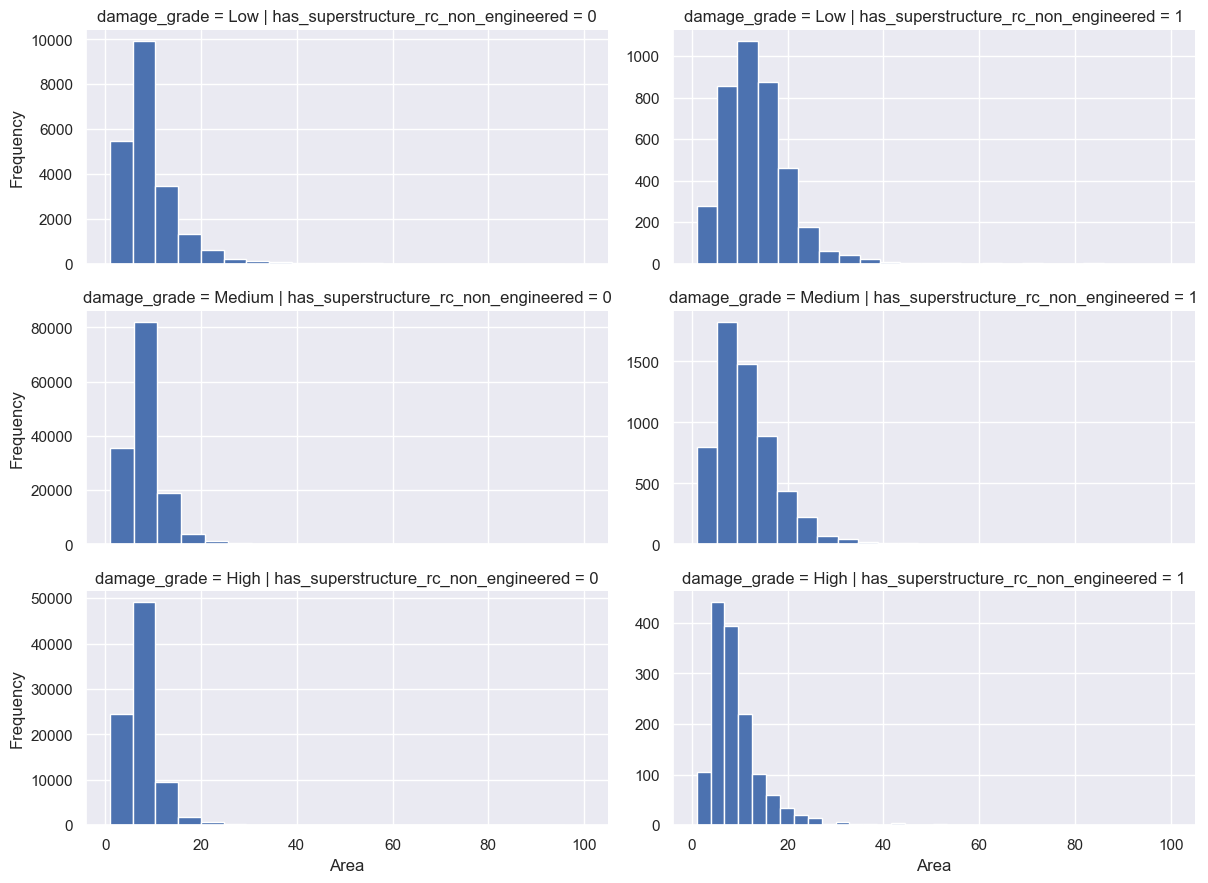

In [40]:
facet_plot(train, 'has_superstructure_rc_non_engineered', 'area_percentage', 'Area')

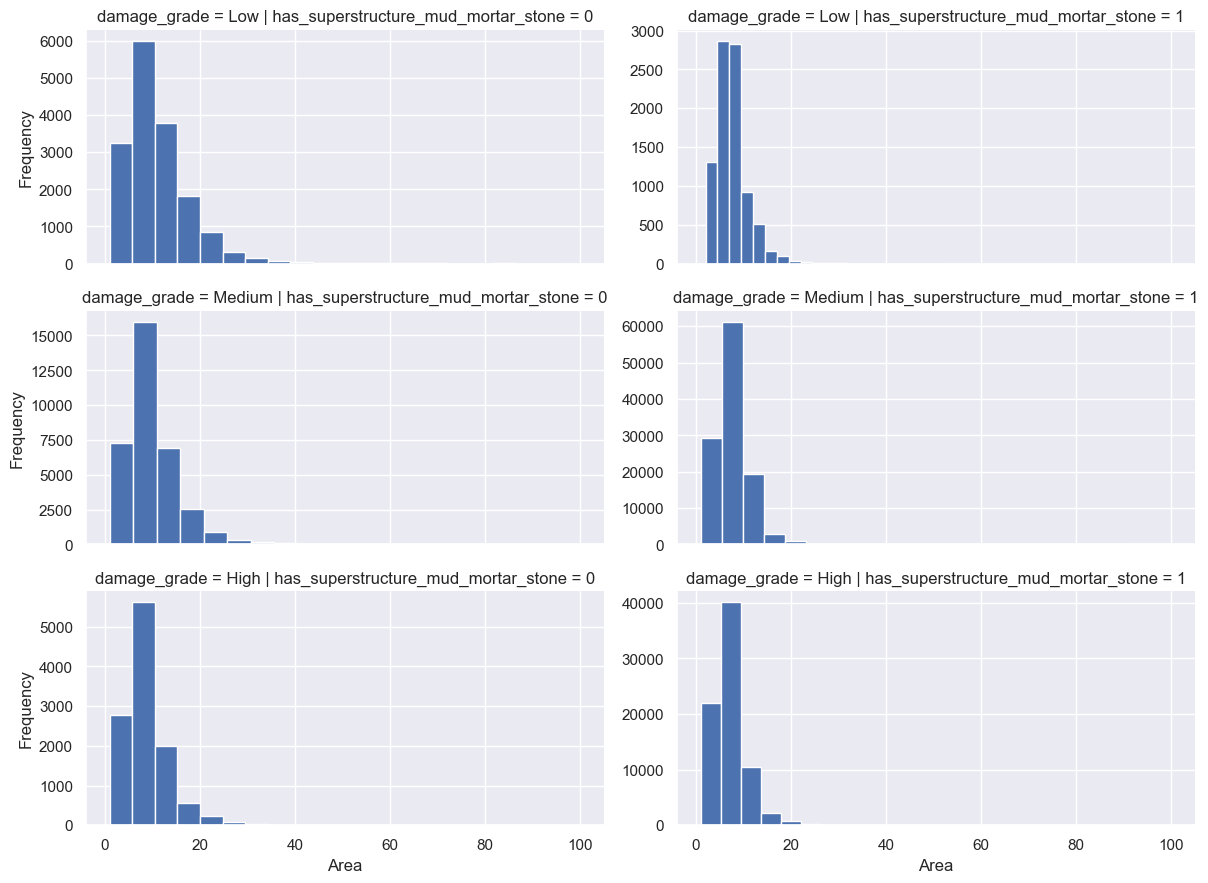

In [41]:
facet_plot(train, 'has_superstructure_mud_mortar_stone', 'area_percentage', 'Area')

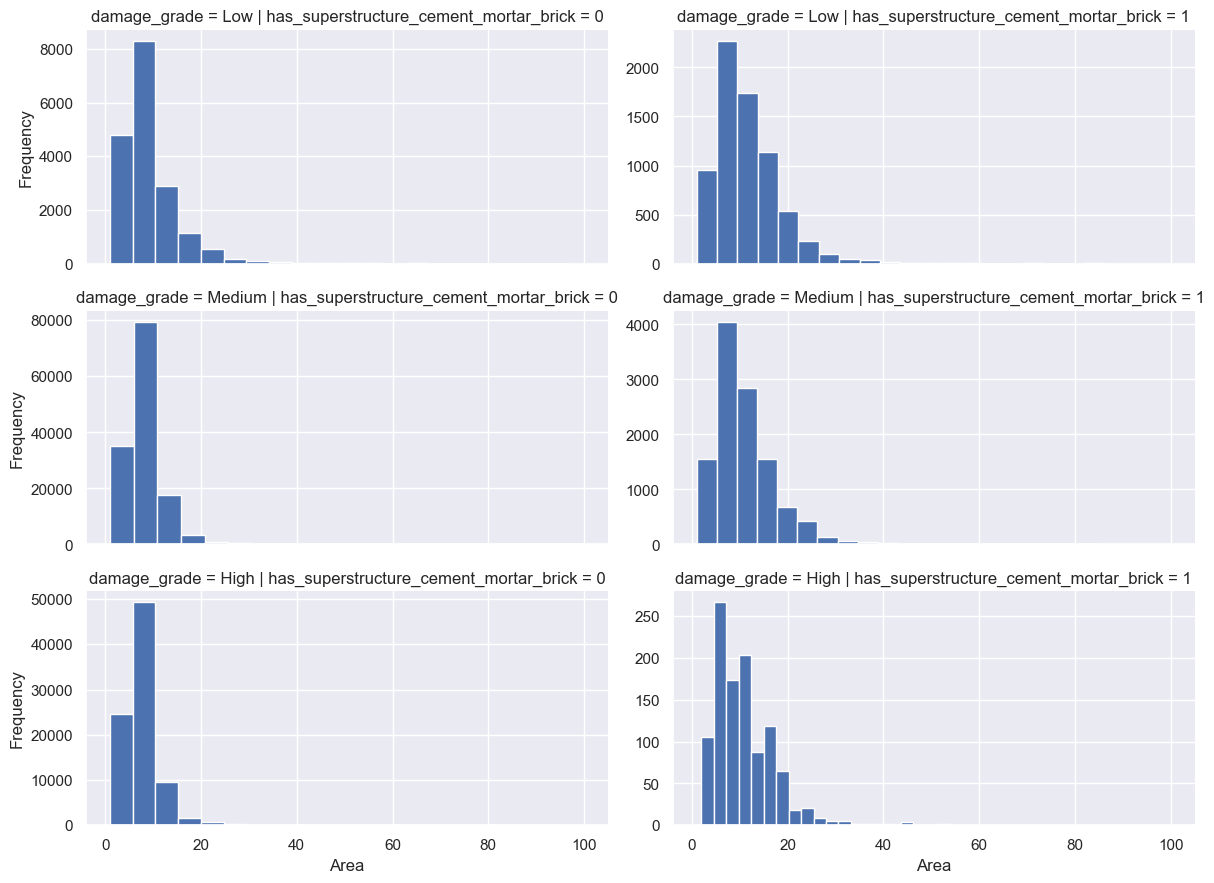

In [42]:
facet_plot(train, 'has_superstructure_cement_mortar_brick', 'area_percentage', 'Area')

### EDA (Recommendation Material and Characteristic)

In [43]:
features = train.copy()
features['damage_grade'] = features['damage_grade'].replace({'Low':1, 'Medium':2, 'High':3})
features['damage_grade'] = features['damage_grade'].astype('int64')
corr_matrix = features.select_dtypes(include=['number']).corr()

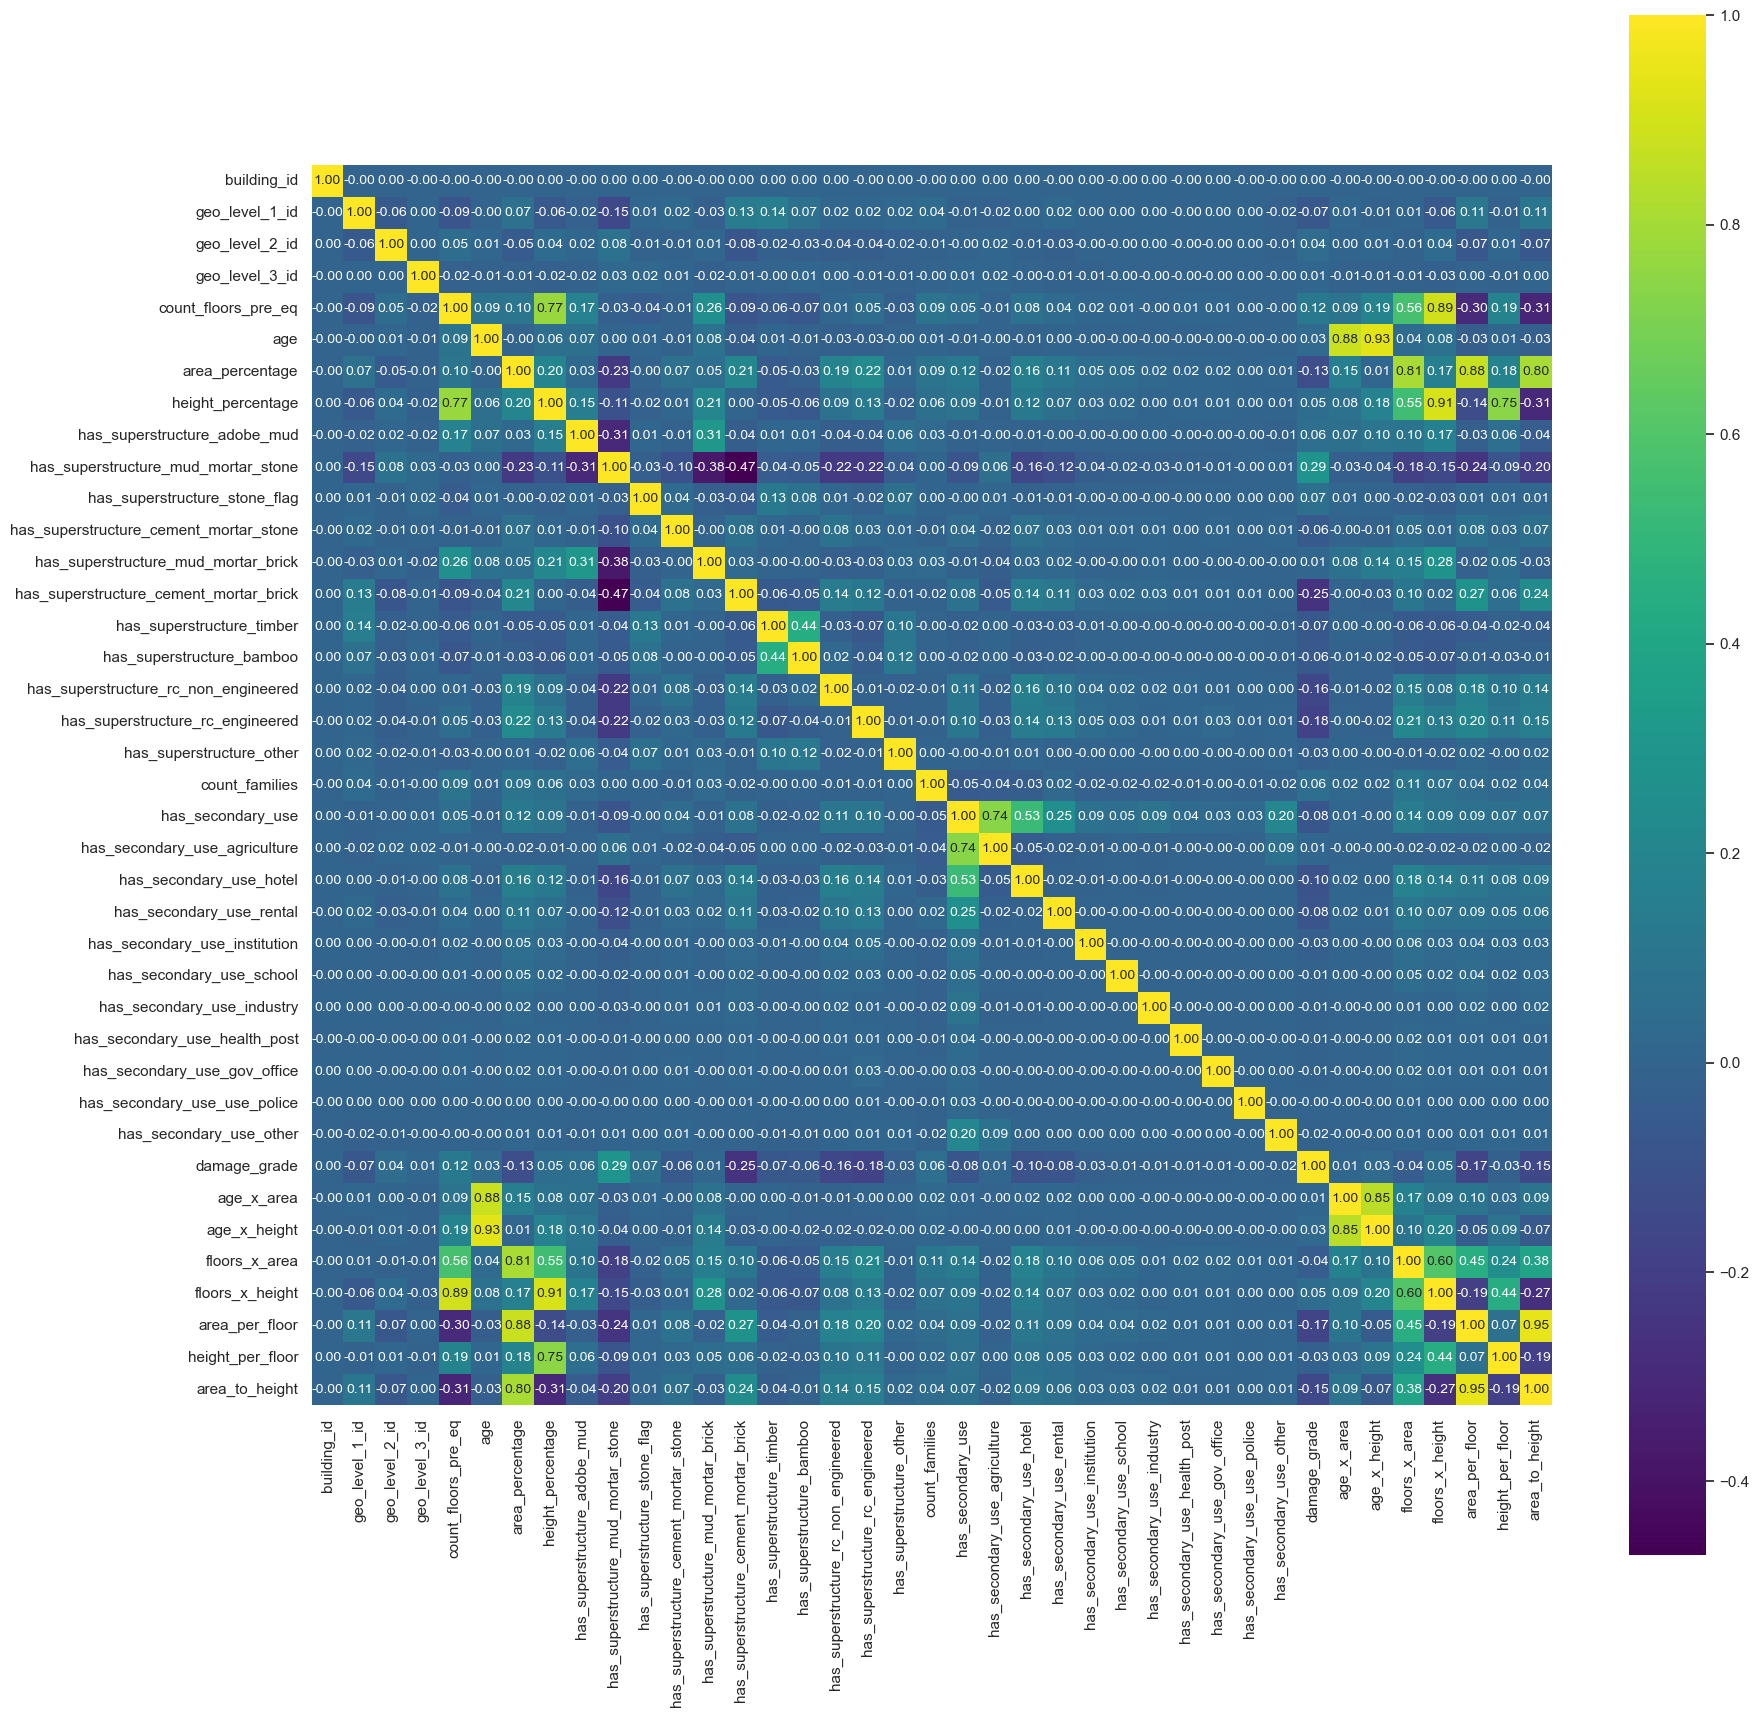

In [44]:
plt.figure(figsize=(20,20))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

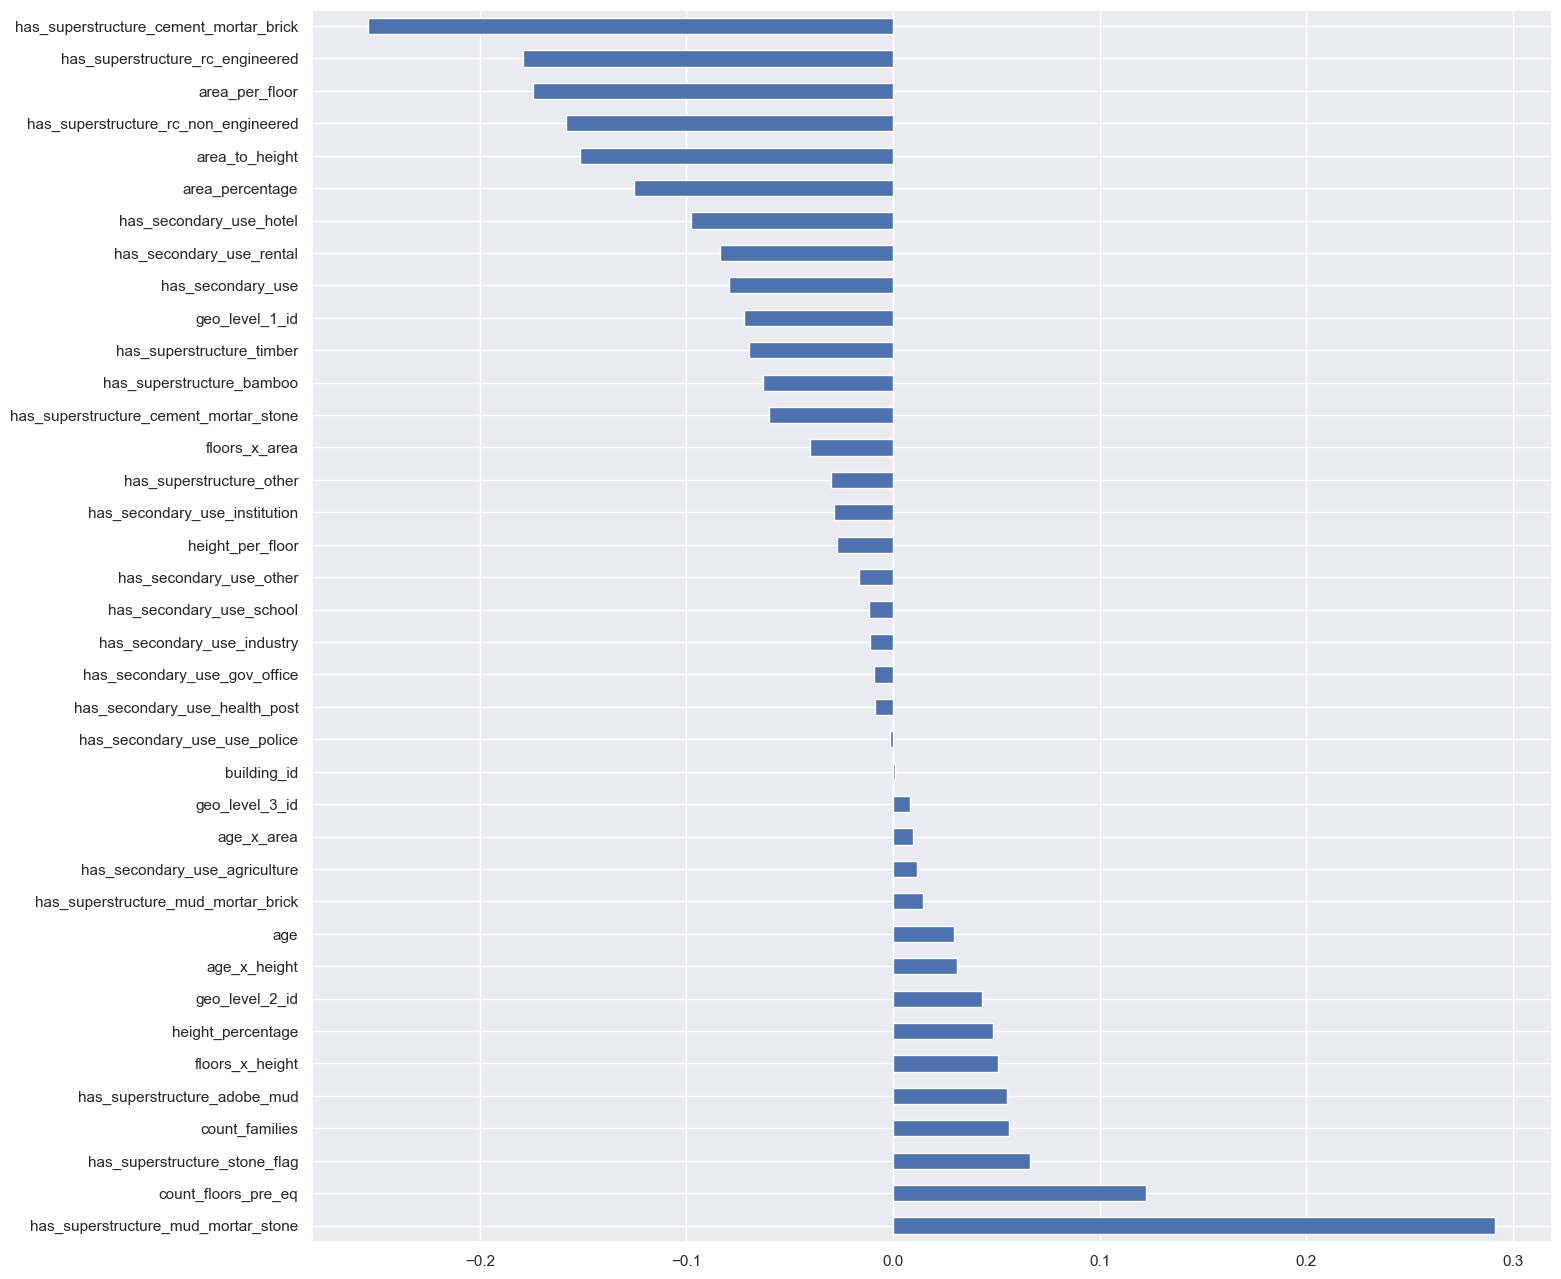

In [45]:
plt.figure(figsize=(16,16))

corr_matrix['damage_grade'].drop('damage_grade').sort_values(ascending=False).plot(kind='barh')
plt.show()

In [46]:
list_corr = corr_matrix['damage_grade'].drop('damage_grade')

#### Recommendation Material

In [47]:
list_corr.loc[[
              'has_superstructure_adobe_mud', 
              'has_superstructure_mud_mortar_stone',
              'has_superstructure_stone_flag',
              'has_superstructure_cement_mortar_stone',
              'has_superstructure_mud_mortar_brick',
              'has_superstructure_cement_mortar_brick', 
              'has_superstructure_timber',
              'has_superstructure_bamboo', 
              'has_superstructure_rc_non_engineered',
              'has_superstructure_rc_engineered', 
              'has_superstructure_other'
              ]]

has_superstructure_adobe_mud              0.055314
has_superstructure_mud_mortar_stone       0.291325
has_superstructure_stone_flag             0.066039
has_superstructure_cement_mortar_stone   -0.060295
has_superstructure_mud_mortar_brick       0.014561
has_superstructure_cement_mortar_brick   -0.254131
has_superstructure_timber                -0.069852
has_superstructure_bamboo                -0.063051
has_superstructure_rc_non_engineered     -0.158145
has_superstructure_rc_engineered         -0.179014
has_superstructure_other                 -0.030224
Name: damage_grade, dtype: float64

#### Recommendation Characteristic

In [48]:
list_corr.loc[['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage']]

count_floors_pre_eq    0.122308
age                    0.029273
area_percentage       -0.125221
height_percentage      0.048130
Name: damage_grade, dtype: float64

## Feature Selection

In [49]:
df = features.copy()
df = df.set_index('building_id')
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object'])

### Feature Selection for Numeric Feature

In [50]:
corr_matrix.loc['height_percentage', 'damage_grade']

0.04813002366999064

In [51]:
print('Korelasi feature height_percentange dengan damage_grade : {:.4f}'.format(corr_matrix.loc['height_percentage', 'damage_grade']))
print('Korelasi feature has_secondary_use_agriculture dengan damage_grade : {:.4f}'.format(corr_matrix.loc['has_secondary_use_agriculture', 'damage_grade']))

Korelasi feature height_percentange dengan damage_grade : 0.0481
Korelasi feature has_secondary_use_agriculture dengan damage_grade : 0.0113


In [52]:
df_num = df_num.drop('has_secondary_use_agriculture', axis=1)
df_num.shape

(260601, 37)

### Feature Selection for Categorical Feature

In [53]:
print(df.dtypes)
print(df.head())

geo_level_1_id                               int64
geo_level_2_id                               int64
geo_level_3_id                               int64
count_floors_pre_eq                          int64
age                                          int64
area_percentage                              int64
height_percentage                            int64
land_surface_condition                      object
foundation_type                             object
roof_type                                   object
ground_floor_type                           object
other_floor_type                            object
position                                    object
plan_configuration                          object
has_superstructure_adobe_mud                 int64
has_superstructure_mud_mortar_stone          int64
has_superstructure_stone_flag                int64
has_superstructure_cement_mortar_stone       int64
has_superstructure_mud_mortar_brick          int64
has_superstructure_cement_morta

In [54]:
df_cat = pd.get_dummies(df_cat)
df_cat.head()

,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,...,foundation_roof_combo_i_q,foundation_roof_combo_i_x,foundation_roof_combo_r_n,foundation_roof_combo_r_q,foundation_roof_combo_r_x,foundation_roof_combo_u_n,foundation_roof_combo_u_q,foundation_roof_combo_u_x,foundation_roof_combo_w_n,foundation_roof_combo_w_q
building_id,,,,,,,,,,,,,,,,,,,,,
802906,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
28830,False,True,False,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
94947,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
590882,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
201944,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


In [55]:
df_cat.shape

(260601, 52)

In [56]:
category_rank_feature = SelectKBest(score_func=chi2, k=38)
rank_feature = category_rank_feature.fit(df_cat, df_num['damage_grade'])
rank_feature.scores_

array([3.14202700e+02, 6.77046429e+01, 6.77640172e+01, 4.15860728e+02,
       2.79293047e+04, 6.39195232e+03, 5.49424844e+03, 8.31579458e+03,
       1.04584801e+03, 1.15697625e+03, 2.80485950e+04, 3.68489235e+03,
       9.75543604e+01, 3.24654211e+04, 6.05516649e+01, 1.22429528e+02,
       7.42291993e+03, 5.10846128e+03, 1.85494082e+04, 4.06602490e+02,
       2.59354872e+02, 1.48779877e+02, 4.93714399e+01, 6.22421247e+02,
       1.09200110e+02, 1.50572497e+02, 3.04753264e+01, 3.34305427e+00,
       1.36435198e+01, 1.65187836e+00, 5.72019260e+01, 3.23110604e+02,
       3.31565900e+01, 1.01176162e+03, 2.26362245e+03, 5.34417037e+01,
       3.96056239e+01, 2.29493063e+02, 1.14143389e+02, 4.15745313e+02,
       4.15578405e+01, 9.77266943e+02, 5.92352653e+01, 2.74376759e+04,
       3.93230654e+03, 3.77119271e+03, 6.64964040e+02, 1.98868761e+03,
       3.34489323e+02, 4.03273239e+03, 6.29891885e+03, 2.60471650e+03])

In [57]:
cat_score = pd.DataFrame(rank_feature.scores_, columns=['Score'])
cat_col = pd.DataFrame(df_cat.columns, columns=['Feature'])
univariate_cat_rank = pd.concat([cat_col, cat_score], axis=1)
univariate_cat_rank.set_index('Feature', inplace=True)
sorted_univariate_cat_rank = univariate_cat_rank.sort_values('Score', ascending=False)

In [58]:
chi2_greater100 = sorted_univariate_cat_rank[sorted_univariate_cat_rank['Score']>100]

### Merge Numeric and Categorical Feature

In [59]:
df_new = pd.concat([df_num, df_cat], axis=1)

In [60]:
df_new.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,foundation_roof_combo_i_q,foundation_roof_combo_i_x,foundation_roof_combo_r_n,foundation_roof_combo_r_q,foundation_roof_combo_r_x,foundation_roof_combo_u_n,foundation_roof_combo_u_q,foundation_roof_combo_u_x,foundation_roof_combo_w_n,foundation_roof_combo_w_q
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,...,False,False,True,False,False,False,False,False,False,False
28830,8,900,2812,2,10,8,7,0,1,0,...,False,False,True,False,False,False,False,False,False,False
94947,21,363,8973,2,10,5,5,0,1,0,...,False,False,True,False,False,False,False,False,False,False
590882,22,418,10694,2,10,6,5,0,1,0,...,False,False,True,False,False,False,False,False,False,False
201944,11,131,1488,3,30,8,9,1,0,0,...,False,False,True,False,False,False,False,False,False,False


## Building Model

### Split Data into Train Data and Validation Data

In [61]:
data = df_new.copy()
y = data['damage_grade']
X = data[list(df_num.columns)+list(chi2_greater100.index)]
X.drop('damage_grade', axis=1, inplace=True)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208480, 73), (52121, 73), (208480,), (52121,))

In [63]:
# ... existing code ...
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [64]:
X_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,foundation_roof_combo_u_q,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,foundation_roof_combo_h_n,plan_configuration_a
0,20,281,7097,2,15,6,7,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,26,886,12157,2,10,6,6,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,26,36,1125,1,0,5,3,0,0,0,...,False,False,True,False,False,False,False,False,False,False
3,13,1372,4555,2,10,6,5,0,1,0,...,False,False,False,False,False,False,False,False,False,False
4,8,206,6064,3,35,6,5,0,1,0,...,False,False,False,False,False,False,False,False,False,False


In [65]:
X_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,foundation_roof_combo_u_q,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,foundation_roof_combo_h_n,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,
315409,6,449,484,2,0,9,8,0,1,0,...,False,False,False,False,False,False,False,False,False,False
838451,27,548,2513,2,0,5,5,0,1,0,...,False,False,False,False,False,False,False,False,False,False
808750,24,780,9035,3,25,4,7,0,1,0,...,False,False,False,False,False,False,False,False,False,False
322968,10,661,6346,3,30,6,7,0,1,0,...,False,False,False,False,False,False,False,False,False,False
212418,10,1207,276,2,15,5,5,0,1,0,...,False,False,False,False,False,False,False,False,False,False


In [66]:
y_train.head().to_frame()

,damage_grade
0,1
1,1
2,1
3,2
4,3


In [67]:
y_test.head().to_frame()

,damage_grade
building_id,
315409,2
838451,3
808750,2
322968,2
212418,3


### Scaling Data

In [68]:
scaler = StandardScaler()

scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']

X_train[scaled_col] = scaler.fit_transform(X_train[scaled_col])
X_test[scaled_col] = scaler.transform(X_test[scaled_col])

In [69]:
X_train.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,foundation_roof_combo_u_q,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,foundation_roof_combo_h_n,plan_configuration_a
0,0.647127,-0.973390,0.222883,0.027721,-0.117220,-0.474557,0.889348,0,1,0,...,False,False,False,False,False,False,False,False,False,False
1,1.396040,0.465834,1.600718,0.027721,-0.183974,-0.474557,0.387605,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,1.396040,-1.556216,-1.403289,-1.324385,-0.317482,-0.691258,-1.117626,0,0,0,...,False,False,True,False,False,False,False,False,False,False
3,-0.226606,1.621971,-0.469302,0.027721,-0.183974,-0.474557,-0.114139,0,1,0,...,False,False,False,False,False,False,False,False,False,False
4,-0.850700,-1.151806,-0.058402,1.379827,0.149797,-0.474557,-0.114139,0,1,0,...,False,False,False,False,False,False,False,False,False,False


In [70]:
X_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,foundation_roof_combo_u_q,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,foundation_roof_combo_h_n,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,
315409,-1.100338,-0.573737,-1.577833,0.027721,-0.317482,0.175545,1.391092,0,1,0,...,False,False,False,False,False,False,False,False,False,False
838451,1.520859,-0.338228,-1.025337,0.027721,-0.317482,-0.691258,-0.114139,0,1,0,...,False,False,False,False,False,False,False,False,False,False
808750,1.146402,0.213673,0.750600,1.379827,0.016289,-0.907959,0.889348,0,1,0,...,False,False,False,False,False,False,False,False,False,False
322968,-0.601063,-0.069414,0.018386,1.379827,0.083043,-0.474557,0.889348,0,1,0,...,False,False,False,False,False,False,False,False,False,False
212418,-0.601063,1.229456,-1.634471,0.027721,-0.117220,-0.691258,-0.114139,0,1,0,...,False,False,False,False,False,False,False,False,False,False


### Using Cross Validation

Definisikan fungsi untuk membuat *confusion matrix*

In [71]:
def make_confusion_matrix(pred, title):
    cam = confusion_matrix(y_test, pred)
    sns.heatmap(cam, annot=True, cmap='viridis', 
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Using {} Algorithm'.format(title))
    plt.show()

#### Logistic Regression

In [72]:
model_cv_1 = LogisticRegression(random_state=0)
kfold = KFold(n_splits=10)
scores_1 = cross_val_score(model_cv_1, X_train, y_train, scoring="f1_micro", cv=kfold)
result_1 = scores_1.mean()
print('Average F1 Score (Micro) for Logistic Algorithm is : {}'.format(result_1))

Average F1 Score (Micro) for Logistic Algorithm is : 0.45294496087649644


#### Decision Tree

In [73]:
model_cv_2 = DecisionTreeClassifier(random_state=0)
kfold = KFold(n_splits=10)
scores_2 = cross_val_score(model_cv_2, X_train, y_train, scoring="f1_micro", cv=kfold)
result_2 = scores_2.mean()
print('Average F1 Score (Micro) for Decision Tree is : {}'.format(result_2))

Average F1 Score (Micro) for Decision Tree is : 0.7357539365875772


#### K-Nearest Neighbors

In [74]:
model_cv_3 = KNeighborsClassifier()
kfold = KFold(n_splits=10)
scores_3 = cross_val_score(model_cv_3, X_train, y_train, scoring="f1_micro", cv=kfold)
result_3 = scores_3.mean()
print('Average F1 Score (Micro) for K-Nearest Neighbors is : {}'.format(result_3))

Average F1 Score (Micro) for K-Nearest Neighbors is : 0.6114970435777196


#### Linear Discriminant Analysis

In [75]:
model_cv_4 = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=10)
scores_4 = cross_val_score(model_cv_4, X_train, y_train, scoring="f1_micro", cv=kfold)
result_4 = scores_4.mean()
print('Average F1 Score (Micro) for Linear Discriminant Analysis is : {}'.format(result_4))

Average F1 Score (Micro) for Linear Discriminant Analysis is : 0.6015327271185799


#### Naive Bayes

In [76]:
model_cv_5 = GaussianNB()
kfold = KFold(n_splits=10)
scores_5 = cross_val_score(model_cv_5, X_train, y_train, scoring="f1_micro", cv=kfold)
result_5 = scores_5.mean()
print('Average F1 Score (Micro) for Naive Bayes is : {}'.format(result_5))

Average F1 Score (Micro) for Naive Bayes is : 0.5656131665089512


#### Extreme Gradient Boosting

In [77]:
model_cv_6 = XGBClassifier(verbosity=0)
kfold = KFold(n_splits=10)
scores_6 = cross_val_score(model_cv_6, X_train, y_train - 1, scoring="f1_micro", cv=kfold)
result_6 = scores_6.mean()
print('Average F1 Score (Micro) for Extreme Gradient Boosting is : {}'.format(result_6))

Average F1 Score (Micro) for Extreme Gradient Boosting is : 0.7745427424032819


#### Random Forest

In [78]:
model_cv_7 = RandomForestClassifier(random_state=0)
kfold = KFold(n_splits=10)
scores_7 = cross_val_score(model_cv_7, X_train, y_train, scoring="f1_micro", cv=kfold)
result_7 = scores_7.mean()
print('Average F1 Score (Micro) for Random Forest is : {}'.format(result_7))

Average F1 Score (Micro) for Random Forest is : 0.7799580525138248


### Fit and Predict Several Algorithm

#### Logistic Regression

              precision    recall  f1-score   support

           1       0.23      0.68      0.34      4979
           2       0.58      0.29      0.39     29703
           3       0.39      0.50      0.44     17439

    accuracy                           0.40     52121
   macro avg       0.40      0.49      0.39     52121
weighted avg       0.48      0.40      0.40     52121



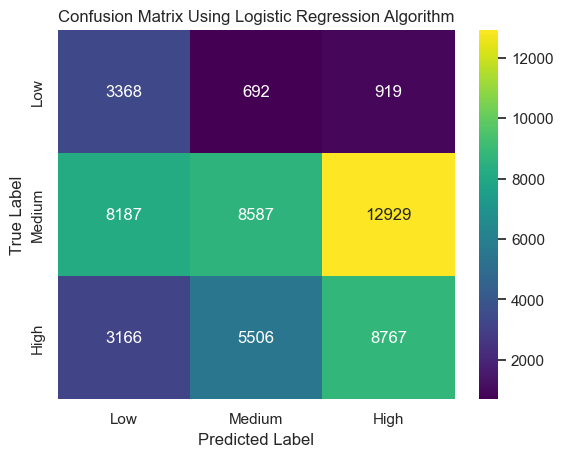

Train F1 Score (Micro) for Logistic Regression Algorithm is : 0.5285659660132483
Test F1 Score (Micro) for Logistic Regression Algorithm is : 0.3975748738512308


In [79]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)
train_pred_1 = model_1.predict(X_train)

print(classification_report(y_test, pred_1))
make_confusion_matrix(pred_1, 'Logistic Regression')
train_score_1 = f1_score(y_train, train_pred_1, average='micro')
score_1 = f1_score(y_test, pred_1, average='micro')
print('Train F1 Score (Micro) for Logistic Regression Algorithm is : {}'.format(train_score_1))
print('Test F1 Score (Micro) for Logistic Regression Algorithm is : {}'.format(score_1))

#### Decision Tree

              precision    recall  f1-score   support

           1       0.43      0.50      0.46      4979
           2       0.70      0.68      0.69     29703
           3       0.60      0.60      0.60     17439

    accuracy                           0.64     52121
   macro avg       0.58      0.59      0.59     52121
weighted avg       0.64      0.64      0.64     52121



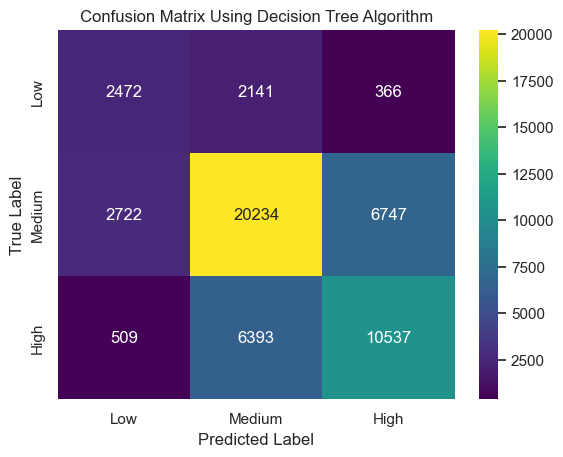

Train F1 Score (Micro) for Decision Tree Algorithm is : 0.9919363001450792
Test F1 Score (Micro) for Decision Tree Algorithm is : 0.6378043399013833


In [80]:
model_2 = DecisionTreeClassifier()
model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_test)
train_pred_2 = model_2.predict(X_train)

print(classification_report(y_test, pred_2))
make_confusion_matrix(pred_2, 'Decision Tree')
train_score_2 = f1_score(y_train, train_pred_2, average='micro')
score_2 = f1_score(y_test, pred_2, average='micro')
print('Train F1 Score (Micro) for Decision Tree Algorithm is : {}'.format(train_score_2))
print('Test F1 Score (Micro) for Decision Tree Algorithm is : {}'.format(score_2))

#### K-Nearest Neighbors

              precision    recall  f1-score   support

           1       0.40      0.46      0.43      4979
           2       0.63      0.65      0.64     29703
           3       0.48      0.43      0.46     17439

    accuracy                           0.56     52121
   macro avg       0.50      0.52      0.51     52121
weighted avg       0.56      0.56      0.56     52121



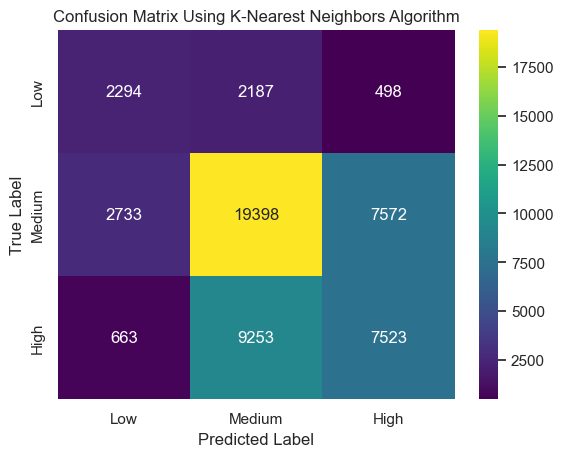

Train F1 Score (Micro) for K-Nearest Neighbors Algorithm is : 0.7773091759730985
Test F1 Score (Micro) for K-Nearest Neighbors Algorithm is : 0.5605226300339594


In [81]:
model_3 = KNeighborsClassifier()
model_3.fit(X_train, y_train)
pred_3 = model_3.predict(X_test)
train_pred_3 = model_3.predict(X_train)

print(classification_report(y_test, pred_3))
make_confusion_matrix(pred_3, 'K-Nearest Neighbors')
train_score_3 = f1_score(y_train, train_pred_3, average='micro')
score_3 = f1_score(y_test, pred_3, average='micro')
print('Train F1 Score (Micro) for K-Nearest Neighbors Algorithm is : {}'.format(train_score_3))
print('Test F1 Score (Micro) for K-Nearest Neighbors Algorithm is : {}'.format(score_3))

#### Linear Discriminant Analysis

              precision    recall  f1-score   support

           1       0.46      0.55      0.50      4979
           2       0.63      0.62      0.63     29703
           3       0.47      0.47      0.47     17439

    accuracy                           0.56     52121
   macro avg       0.52      0.55      0.53     52121
weighted avg       0.56      0.56      0.56     52121



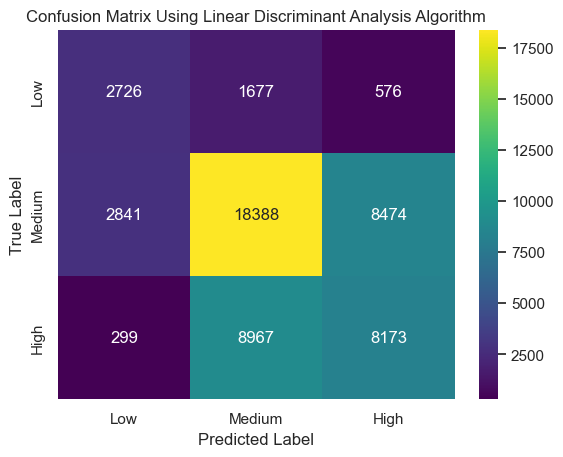

Train F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : 0.6530500354262965
Test F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : 0.5619040310047774


In [82]:
model_4 = LinearDiscriminantAnalysis()
model_4.fit(X_train, y_train)
pred_4 = model_4.predict(X_test)
train_pred_4 = model_4.predict(X_train)

print(classification_report(y_test, pred_4))
make_confusion_matrix(pred_4, 'Linear Discriminant Analysis')
train_score_4 = f1_score(y_train, train_pred_4, average='micro')
score_4 = f1_score(y_test, pred_4, average='micro')
print('Train F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : {}'.format(train_score_4))
print('Test F1 Score (Micro) for Linear Discriminant Analysis Algorithm is : {}'.format(score_4))

#### Naive Bayes

              precision    recall  f1-score   support

           1       0.37      0.58      0.45      4979
           2       0.68      0.14      0.23     29703
           3       0.40      0.88      0.55     17439

    accuracy                           0.43     52121
   macro avg       0.48      0.53      0.41     52121
weighted avg       0.56      0.43      0.36     52121



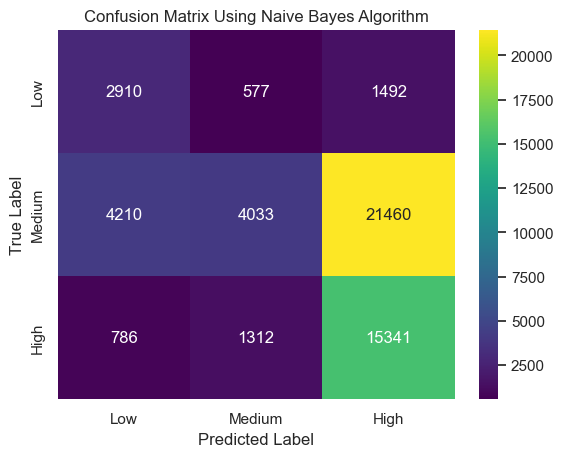

Train F1 Score (Micro) for Naive Bayes Algorithm is : 0.5714233498656051
Test F1 Score (Micro) for Naive Bayes Algorithm is : 0.42754360046814144


In [83]:
model_5 = GaussianNB()
model_5.fit(X_train, y_train)
pred_5 = model_5.predict(X_test)
train_pred_5 = model_5.predict(X_train)

print(classification_report(y_test, pred_5))
make_confusion_matrix(pred_5, 'Naive Bayes')
train_score_5 = f1_score(y_train, train_pred_5, average='micro')
score_5 = f1_score(y_test, pred_5, average='micro')
print('Train F1 Score (Micro) for Naive Bayes Algorithm is : {}'.format(train_score_5))
print('Test F1 Score (Micro) for Naive Bayes Algorithm is : {}'.format(score_5))

#### Extreme Gradient Boosting

              precision    recall  f1-score   support

           0       0.62      0.52      0.56      4979
           1       0.72      0.81      0.77     29703
           2       0.71      0.60      0.65     17439

    accuracy                           0.71     52121
   macro avg       0.68      0.64      0.66     52121
weighted avg       0.71      0.71      0.71     52121



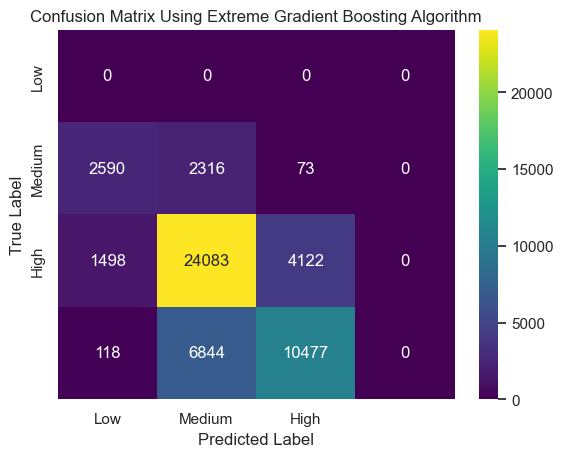

Train F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : 0.8070644533666228
Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : 0.7127645286928493


In [84]:
model_6 = XGBClassifier(verbosity=0, tree_method='gpu_hist')
model_6.fit(X_train, y_train - 1)
pred_6 = model_6.predict(X_test)
train_pred_6 = model_6.predict(X_train)

print(classification_report(y_test - 1, pred_6))
make_confusion_matrix(pred_6, 'Extreme Gradient Boosting')
train_score_6 = f1_score(y_train - 1, train_pred_6, average='micro')
score_6 = f1_score(y_test - 1, pred_6, average='micro')
print('Train F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : {}'.format(train_score_6))
print('Test F1 Score (Micro) for Extreme Gradient Boosting Algorithm is : {}'.format(score_6))

#### Random Forest

              precision    recall  f1-score   support

           1       0.58      0.50      0.54      4979
           2       0.71      0.78      0.74     29703
           3       0.67      0.57      0.62     17439

    accuracy                           0.69     52121
   macro avg       0.65      0.62      0.63     52121
weighted avg       0.68      0.69      0.68     52121



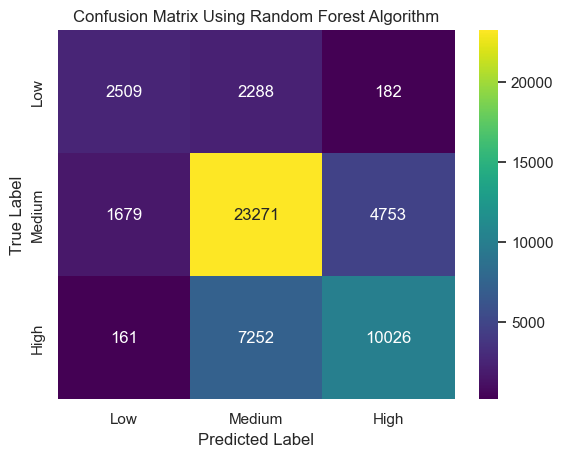

Train F1 Score (Micro) for Random Forest Algorithm is : 0.991933488534251
Test F1 Score (Micro) for Random Forest Algorithm is : 0.6869783772375818


In [85]:
model_7 = RandomForestClassifier(random_state=0)
model_7.fit(X_train, y_train)
pred_7 = model_7.predict(X_test)
train_pred_7 = model_7.predict(X_train)

print(classification_report(y_test, pred_7))
make_confusion_matrix(pred_7, 'Random Forest')
train_score_7 = f1_score(y_train, train_pred_7, average='micro')
score_7 = f1_score(y_test, pred_7, average='micro')
print('Train F1 Score (Micro) for Random Forest Algorithm is : {}'.format(train_score_7))
print('Test F1 Score (Micro) for Random Forest Algorithm is : {}'.format(score_7))

### Comparing Algorithm

In [86]:
names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbors', 'Linear Discriminant Analysis',
         'Naive Bayes', 'Extreme Gradient Boosting', 'Random Forest']
cv_score_f1 = [result_1, result_2, result_3, result_4, result_5, result_6, result_7]
train_score_f1 = [train_score_1, train_score_2, train_score_3, train_score_4, train_score_5, train_score_6, train_score_7]
score_f1 = [score_1, score_2, score_3, score_4, score_5, score_6, score_7]

In [87]:
compare = pd.DataFrame()
compare['Algorithm'] = names
compare['CV F1 Score'] = cv_score_f1
compare['F1 Score (Train)'] = train_score_f1
compare['F1 Score (Test)'] = score_f1
compare

,Algorithm,CV F1 Score,F1 Score (Train),F1 Score (Test)
0,Logistic Regression,0.452945,0.528566,0.397575
1,Decision Tree,0.735754,0.991936,0.637804
2,K-Nearest Neighbors,0.611497,0.777309,0.560523
3,Linear Discriminant Analysis,0.601533,0.653050,0.561904
4,Naive Bayes,0.565613,0.571423,0.427544
5,Extreme Gradient Boosting,0.774543,0.807064,0.712765
6,Random Forest,0.779958,0.991933,0.686978


### Hyperparameter Tuning

#### Extreme Gradient Boosting Parameter Tuning

In [88]:
xgb_params = {
    'n_estimators': range(50, 201, 50),
    'max_depth': range(3, 15),
    'learning_rate': [0.01, 0.1, 0.2],  # Add learning rate
    'subsample': [0.6, 0.8, 1.0],       # Add subsample
    'colsample_bytree': [0.6, 0.8, 1.0],# Add colsample_bytree
    'alpha': [0, 0.1, 0.5],             # Add L1 regularization
    'lambda': [0, 0.1, 0.5]             # Add L2 regularization
}
xgb_model = XGBClassifier(tree_method="gpu_hist", verbosity=0)
kfold = KFold(n_splits=4)
rscv_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, n_iter=5,
                              scoring='f1_micro', cv=kfold, random_state=0, n_jobs=-1)

rscv_xgb.fit(X, y - 1)
print("Optimal hyperparameter combination for XGBClassifier:", rscv_xgb.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv_xgb.best_score_)

Optimal hyperparameter combination for XGBClassifier: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 14, 'learning_rate': 0.2, 'lambda': 0, 'colsample_bytree': 1.0, 'alpha': 0.5}

Mean cross-validated training accuracy score: 0.7302619755655181


### Build Model With Parameter Tuning

#### Extreme Gradient Boosting

In [89]:
tuning_xgb_model = XGBClassifier(n_estimators=150, max_depth=10, verbosity=0, tree_method="gpu_hist")
tuning_xgb_model.fit(X_train, y_train - 1)
pred_xgb = tuning_xgb_model.predict(X_test)
train_pred_xgb = tuning_xgb_model.predict(X_train)
print('F1 Score (Micro) on Training Data :', f1_score(y_train - 1, train_pred_xgb, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test - 1, pred_xgb, average='micro'))

F1 Score (Micro) on Training Data : 0.908870069840413
F1 Score (Micro) on Testing Data : 0.7356343892097236


### Feature Importance

#### Extreme Gradient Boosting

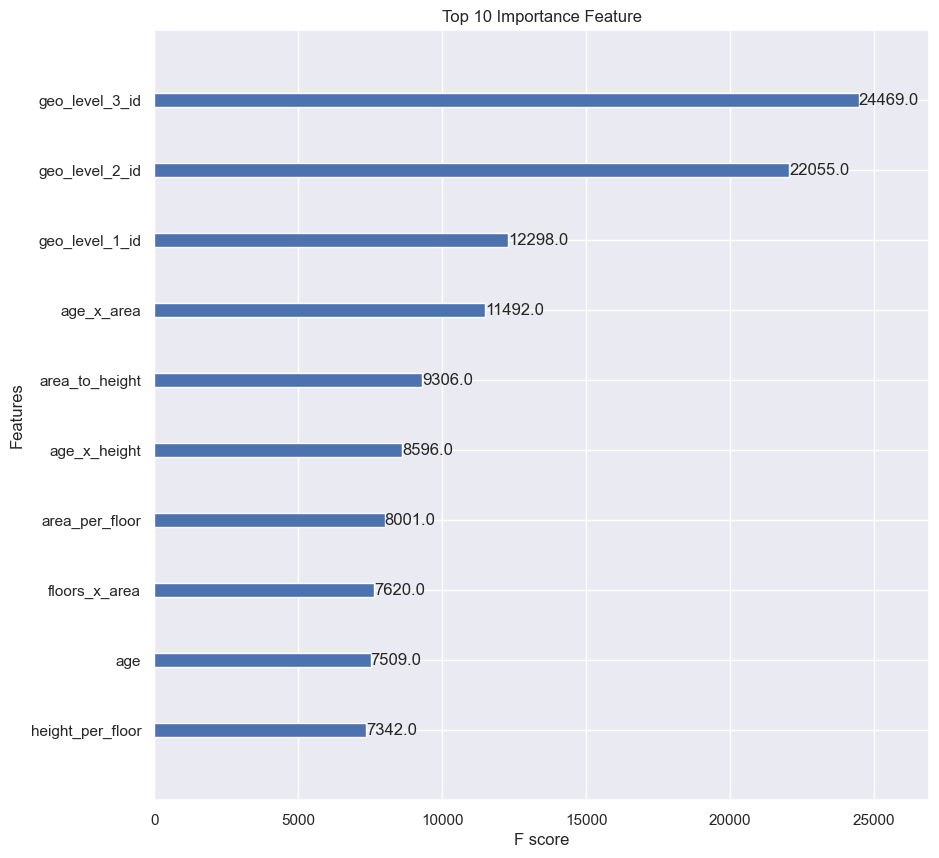

In [90]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(tuning_xgb_model, max_num_features=10, ax=ax)
plt.title('Top 10 Importance Feature')
plt.show()

## Final Model

In [91]:
def final_confusion_matrix(pred, title):
    cam = confusion_matrix(y, pred)
    sns.heatmap(cam, annot=True, cmap='viridis', 
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'],
                fmt="d")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix Using {} Algorithm'.format(title))
    plt.show()

In [92]:
scaler_final = StandardScaler()
scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']
X[scaled_col] = scaler_final.fit_transform(X[scaled_col])

F1 Score (Micro) on Training Data : 0.9332657971381537
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     25124
           1       0.92      0.96      0.94    148259
           2       0.94      0.88      0.91     87218

    accuracy                           0.93    260601
   macro avg       0.95      0.93      0.93    260601
weighted avg       0.93      0.93      0.93    260601



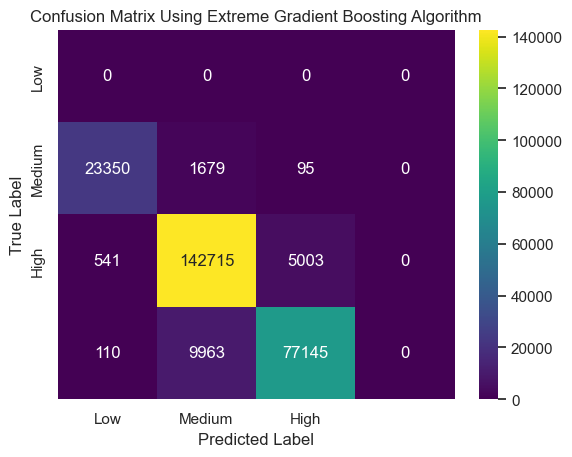

In [93]:
final_model = XGBClassifier(n_estimators=200, max_depth=12, verbosity=0, tree_method="gpu_hist")

# Fit the model
final_model.fit(X, y - 1)

# Predict and evaluate
pred_final_model = final_model.predict(X)
print('F1 Score (Micro) on Training Data :', f1_score(y - 1, pred_final_model, average='micro'))
print('Classification report: \n', classification_report(y - 1, pred_final_model))
final_confusion_matrix(pred_final_model, 'Extreme Gradient Boosting')

F1 Score (Micro) on Training Data : 0.8990238087204921
F1 Score (Micro) on Testing Data : 0.7316436752940274


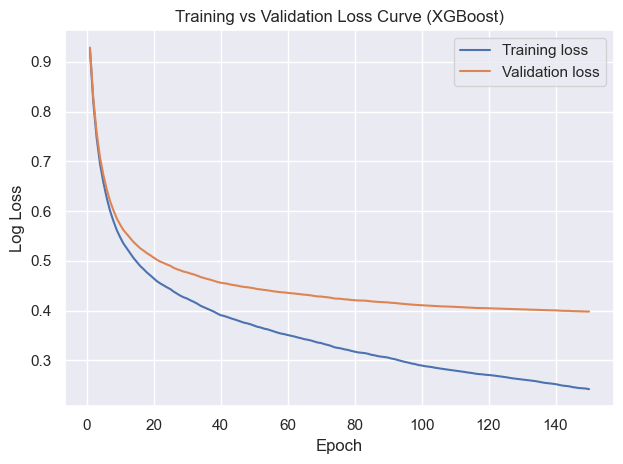

In [94]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split untuk eval_set
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train - 1, test_size=0.2, random_state=42)

# Buat model tuning (tanpa eval_metric di fit)
tuning_xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=10,
    verbosity=0,
    tree_method="gpu_hist",
    use_label_encoder=False,
    objective="multi:softprob",  # untuk multiclass (atau 'binary:logistic' untuk binary)
    eval_metric="mlogloss"       # letakkan di sini, bukan di fit
)

# Fit dengan eval_set untuk dapatkan training & validation loss
tuning_xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_train_split, y_train_split), (X_val_split, y_val_split)],
    verbose=False
)

# Prediksi dan evaluasi
pred_xgb = tuning_xgb_model.predict(X_test)
train_pred_xgb = tuning_xgb_model.predict(X_train)

print('F1 Score (Micro) on Training Data :', f1_score(y_train - 1, train_pred_xgb, average='micro'))
print('F1 Score (Micro) on Testing Data :', f1_score(y_test - 1, pred_xgb, average='micro'))

# Plot learning curve
results = tuning_xgb_model.evals_result()
epochs = range(1, len(results['validation_0']['mlogloss']) + 1)
plt.plot(epochs, results['validation_0']['mlogloss'], label='Training loss')
plt.plot(epochs, results['validation_1']['mlogloss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Loss Curve (XGBoost)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Predict on Unseen Data

Sekarang, akan diprediksi tingkat kerusakan pada bangunan yang ada pada data uji.

In [95]:
test_data = test_value.copy()
test_data = test_data.set_index('building_id')
test_data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,...,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,...,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,...,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


In [96]:
test_data_num = test_data.select_dtypes(include=['int64', 'float64'])
test_data_cat = test_data.select_dtypes(include=['object'])

In [97]:
test_data_num = test_data_num.drop('has_secondary_use_agriculture', axis=1)

In [98]:
test_data_cat = pd.get_dummies(test_data_cat)

In [99]:
new_test_data = pd.concat([test_data_num, test_data_cat], axis=1)

In [101]:
scaler = StandardScaler()
scaled_test = new_test_data.copy()
data_train = df_new.copy()
scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']

scaled_train = data_train[scaled_col]
scaler.fit(scaled_train)
feature_scaled_test = scaled_test[scaled_col]
feature_scaled_test = scaler.transform(feature_scaled_test)
scaled_test[scaled_col] = feature_scaled_test
data_test = scaled_test.copy()

In [102]:
data_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,
300051,0.385835,-0.254597,1.384702,1.195989,-0.088832,-0.231785,0.294845,0,1,0,...,False,False,False,False,False,False,False,False,True,False
99355,-0.983414,-1.357066,1.571189,-0.178274,-0.020866,1.134266,-0.226419,0,1,0,...,False,False,False,False,False,False,False,False,True,False
890251,1.008221,-1.652673,1.038329,-0.178274,-0.292732,-0.914810,-0.226419,0,1,0,...,False,False,False,False,False,False,False,False,True,False
745817,1.506130,-1.604213,-1.542599,-1.552536,-0.360698,2.500317,-1.268946,0,0,0,...,False,False,False,False,False,False,False,False,True,False
421793,0.385835,-0.998461,0.469543,1.195989,-0.156799,-0.004110,0.816109,0,1,0,...,False,False,False,False,False,False,False,False,True,False


In [108]:
# Ambil urutan kolom dari data training yang digunakan untuk training model
expected_features = final_model.feature_names_in_

# Pastikan hanya kolom yang ada di data_test
testing = data_test[[col for col in expected_features if col in data_test.columns]]

# Tambahkan kolom yang hilang dengan nilai 0
for col in expected_features:
    if col not in testing.columns:
        testing[col] = 0

# Susun kembali kolom sesuai urutan model
testing = testing[expected_features]


In [109]:
pred_testing_data = final_model.predict(testing)

In [110]:
final = pd.DataFrame()
final['building_id'] = testing.index
final['damage_grade'] = pred_testing_data

In [111]:
final

,building_id,damage_grade
0,300051,2
1,99355,1
2,890251,1
3,745817,0
4,421793,2
...,...,...
86863,310028,1
86864,663567,1
86865,1049160,1
86866,442785,1


In [112]:
final.to_csv('Damage Grade Prediction.csv', index=False)
